# SYNERGY BETWEEN OCEANIC OBSERVATION SYSTEMS IN TURBULENT NORTH ATLANTIC REGIONS 


The paper related to the code implemented can be found here : [paper](https://drive.google.com/open?id=1aeP1qdn5Qe0qL14B-gfT8V0ily8yPX6N).

In the following we briefly sum up the procedure detailed in the paper.


## Introduction 

*Today satellites provide a surface signature of the temperature with a high spatial frequency: ie a good horizontal resolution but a low vertical resolution.Thanks to the ARGO database collected by buoys making vertical surveys, one has a precise but sparse knowledge of the vertical thermal structure of the ocean. The objective of this project is to develop a methodology to statistically combine additional information to obtain a 3D time series sufficiently resolved horizontally and vertically to follow the eddies.
It is based on a regression classification method that allows both to classify the temperature profiles and to propose a linear model between the satellite observations and the information of the buoys according to its label.*

## Theory and model 

Temperature profiles can be approximated linearly from satellite surfacic data with coefficient that varies according to the class surfacic data belongs known as a latent mode. Given Y the temperature profile in depth and X the surfacic data, Z the latent mode we obtain :

$$ Y|_{X,Z=k} \sim \mathcal{N}(X \beta_k, \Sigma_k)$$

With $ \beta_k$ the linear coefficient and $\Sigma_k$ covariance matrix.

**Sattelite data available :**

- patches of 13x13 SST

Sea surface temperature (SST) is the water temperature close to the ocean's surface. Surface here means between 1 millimetre (0.04 in) and 20 metres (70 ft) below the sea surface.
SST changes diurnally, like the air above it, but to a lesser degree. There is less SST variation on breezy days than on calm days.
 
- patches of 13x13 SLA

Sea Level Anomalies (SLA) are provided along-track for all available satellite altimeter missions. They describe the difference between the actual sea surface height (SSH) and a mean sea surface height (MSSH). All measurements are already corrected by the most actual geophysical corrections (e.g. tides and atmospheric delays).

**ARGO Data :** 
- Temperature profiles (36 depth levels) from the surface down to about -1000m. This is in the variable "TEMP" 
- The classification result of the profile. It's an integer between 1 and 4, in the variable "LABEL" 

Profile labels are taken from Guillaume Maze publication:  *A Profile Classification Model from North-Atlantic Argo temperature data.* SEANOE Sea scientific open data edition / One may found it's GitHub here :[obidam/pcm](https://github.com/obidam/pcm).

They will be used to qualitatively evaluate the clusterization process.

**Additional data:** 

- Coordinates of each patch points are in "lat" and "lon". The grid is not regular, so each patch point has its own latitude and longitude.
- The date of the profile is in "tim" and the depth levels of the profile in "dpt".
- There are "n_obs" samples for each of these.



## Parametrization

We want to constraint ourself to work with a realistic number of data. Let's assume we have 706 profiles. If we do not apply dimension reduction techniques, our model will need to fit : 

$$ N_{param} = N_{class} (N_{features}N_{Target} + N_{COV}) $$
$$ N_{param} = 4* ((13*13 + 13*13) *36 + 36^2)  = 53856$$

So at least 53856/36 = 1496 profiles so that the number of equation is equal to the number of parameter to select.

Which will surely lead to overfitting if trained with 706 profiles.


**Dimension Reduction : Principal Component Analysis (PCA)**

PCA are realized on both feature and target vectors:  0.99 % of the variance is kept for both.

**Selecting the number of mode: Bayesian Information Criterion (BIC)**

*In statistics, the Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred. It is based on the likelihood function and on the number of parameters of the model involved. When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. BIC  attempts to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC.*

In our case, the Bayesian Information Criterion (BIC) is calculted given the following formula :

<img src="https://latex.codecogs.com/svg.latex?\Large&space;BIC=-2*log(lik)+n_{params}*log(size_{samples})" title="BIC" />

We compute the BIC to choose how many modes we should identify. 

Here 3 or 4 modes have been identified as optimal.

**Convergence to the best solution :**

We realize several EM algorithm realizing clusterization + regression fitting.

To combine several simulations we need to re-assign labels first : to do so we minimize chamfer distance on the latitude, longitude corresponding to each label. 

Once the labels re-assigned, we have for each sample different labelization, we take the most frequent and hardcode it as the combined_label.

Finally we initialize a new EM with the labels obtained by combination.



## Generating prediction 

Now that we have fitted $\beta_k$ and $\Sigma_k$, we can make a prediction knowing a label/mode.
The infimum of error can now be computed.

**How to estimate the mode :**

In practice we have to estimate the right mode, to do so we estimate the probability density function of each class.

Then for each sample we consider it's mode is the one corresponding to the highest pdf value.

**RMS heatmap are computed at the end**


# DEVELOPPEMENT OF DIFFERENT MODELS

## Imports and library requirements installation 

In [1]:
#!pip install xarray
!pip install netCDF4
#!pip install seaborn
#!pip install pandas 
#!pip install numpy --upgrade

    100% |████████████████████████████████| 3.9MB 10.0MB/s 
    100% |████████████████████████████████| 307kB 27.5MB/s 


In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1-eBbniJNWZ4nBF87XSsyXLfWIbGi2DWt',
                                    dest_path='/content/library.py',
                                    unzip=False)

gdd.download_file_from_google_drive(file_id='11z6CK6wBbaNaqXGYJcYGJKDDwty-hn_n',
                                    dest_path='/content/func.py',
                                    unzip=False)


In [3]:
import warnings
warnings.filterwarnings('ignore')

%config IPCompleter.greedy=True
# load numpy and matplotlib
%pylab inline
pylab.rcParams['figure.figsize']=(8.0,8.0)

from sklearn.cluster import KMeans
import numpy as np
import tqdm
import os
import glob
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import func
import scipy.stats
from scipy.linalg import qr, solve, lstsq
from scipy.stats import multivariate_normal

from numpy import *
from IPython.display import Image
from IPython.core.display import HTML
import library as lib
import random as rd
import matplotlib.image as mpimg
import pandas as pd
from netCDF4 import Dataset
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time
from tqdm import *

from sklearn.utils import linear_assignment_ as la

sns.set(style="ticks")

Populating the interactive namespace from numpy and matplotlib


## Load patches

The netcdf file contains:  
- Temperature profiles (36 depth levels) from the surface down to about -1000m. This is in the variable "TEMP"
- The classification result of this profile. It's an integer between 1 and 4, in the variable "LABEL"
- A patch of Sea Surface Temperature centered on the temperature profile. The patch is 13 x 13 points, so we have 6 values around the profile point. This is in the variable "SST"
- A patch of Sea Level Anomaly centered on the temperature profile. Like SST, the patch is also 13 x 13 points, so we have 6 values around the profile point. This is in the variable "SLA"
- Coordinates of each patch points are in "lat" and "lon". The grid is not regular, so each patch point has its own latitude and longitude.
- The date of the profile is in "tim" and the depth levels of the profile in "dpt".
- There are "n_obs" samples for each of these.

In [4]:
# Get the patches :
gdd.download_file_from_google_drive(file_id='1bsBpUVuK_7YkwT3mAdg93d4liY1EVDoh',
                                    dest_path='/content/ALLPATCHES_NX13_NY13.nc',
                                    unzip=False) 

gdd.download_file_from_google_drive(file_id='1H7MiKypYYjej7LXNAeiIe300UYFV2hkm',
                                    dest_path='/content/NATL12_GSbox_PCM_profils.csv',
                                    unzip=False) 


In [0]:
patch_length_lon = 6 # Half zonal length of the patch
patch_length_lat = 6 # Half meridional length of the patch
filename = ("ALLPATCHES_NX%i_NY%i.nc")%(2*patch_length_lon+1,2*patch_length_lat+1)

# Load patches:
ds = xr.open_dataset(filename)

label = ds['LABEL'].isel().values[np.newaxis]
temp = ds['TEMP'].isel().values
sla = ds['SLA'].isel()#.stack(features=('latitude','longitude'))
sst = ds['SST'].isel()#.stack(features=('latitude','longitude'))

# Eventually reduce the size (now we will use PCA) 
sst = sst.stack(features=('latitude','longitude'))
sla = sla.stack(features=('latitude','longitude')) 

# Merge:
features = np.concatenate((sla, sst), axis=1)
features.shape

lat = ds['lat'].isel()
lon = ds['lon'].isel()

lat  = lat[:,6,6].values
lon = lon[:,6,6].values

In [0]:
lat_lng = zeros((len(lat),2))
lat_lng[:,0]=lat
lat_lng[:,1]=lon

# We take G.Maze labels as "ground_truth": gt_label
gt_label = ndarray.astype(label.squeeze()-1,int)

**Plot one observation :**

Text(0.5, 1.0, 'SLA')

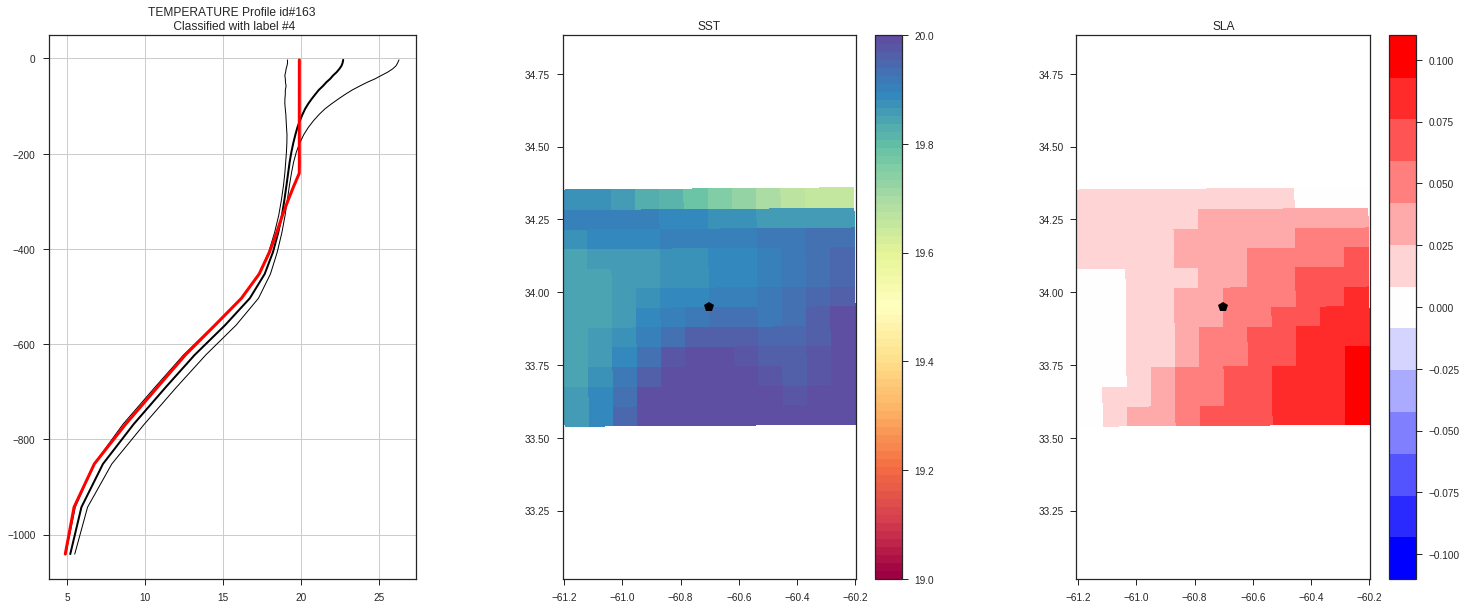

In [7]:
# Load Class mean and std profiles:
PCM = pd.read_csv('NATL12_GSbox_PCM_profils.csv',sep=';',header=0).to_xarray()
PCM['dpt'] = xr.DataArray(ds['dpt'].values, dims='index')
PCM = PCM.rename({"index": "depth"})

# Select the observation index to plot:
# i_obs = 0
i_obs = np.random.randint(0,ds['n_obs'].max()-1,1)[0] # Because n_obs is 1-based
obs_label = ds['LABEL'].isel(n_obs=i_obs)

# Plot it:
fig = plt.figure(figsize=(25, 10))
grid = plt.GridSpec(1, 3, wspace=0.4, hspace=0.3)

def show_loc():
    y = ds['lat'].isel(n_obs=i_obs).isel(latitude=patch_length_lat).isel(longitude=patch_length_lon)
    x = ds['lon'].isel(n_obs=i_obs).isel(latitude=patch_length_lat).isel(longitude=patch_length_lon)
    plt.plot(x, y, 'kp', markersize=10)

# Profile:
ax = plt.subplot(grid[0, 0])
plt.plot(PCM['MU'+str(int(obs_label))],ds['dpt'], color='k', linewidth=2)
plt.plot(PCM['MU'+str(int(obs_label))]-PCM['SI'+str(int(obs_label))],ds['dpt'], color='k', linewidth=1)
plt.plot(PCM['MU'+str(int(obs_label))]+PCM['SI'+str(int(obs_label))],ds['dpt'], color='k', linewidth=1)
plt.plot(ds['TEMP'].isel(n_obs=i_obs), ds['dpt'], color='r', linewidth=3)
ax.set_title( ("TEMPERATURE Profile id#%i\n Classified with label #%i")%(i_obs, ds['LABEL'].isel(n_obs=i_obs)) )
ax.grid('on')

# Sea Surface Temperature Map:
ax = plt.subplot(grid[0, 1])
K = 68
cmap = func.cmap_discretize(plt.cm.Spectral, K)
ext = np.round([ds['SST'].isel(n_obs=i_obs).min(), ds['SST'].isel(n_obs=i_obs).max()])
plt.pcolormesh(ds['lon'].isel(n_obs=i_obs), ds['lat'].isel(n_obs=i_obs), ds['SST'].isel(n_obs=i_obs), cmap=cmap, vmin=ext[0],vmax=ext[1])
show_loc()
ax.axis('equal')
plt.colorbar()
ax.set_title('SST')

# Sea Surface Height:
ax = plt.subplot(grid[0, 2])
K = 13
cmap = func.cmap_discretize(plt.cm.bwr, K)
ext = 1.1*np.round(np.max(np.abs([ds['SLA'].isel(n_obs=i_obs).min(), ds['SLA'].isel(n_obs=i_obs).max()])),2)
plt.pcolormesh(ds['lon'].isel(n_obs=i_obs), ds['lat'].isel(n_obs=i_obs), ds['SLA'].isel(n_obs=i_obs), cmap=cmap, vmin=-ext,vmax=ext)
show_loc()
ax.axis('equal')
plt.colorbar()
ax.set_title('SLA')

## Initiate features X and target variable Y

Features X is (SLA, SST) flaten while target Y is the temperature


In [0]:
Y = temp
X = features

# I - Remove Nan Value
X = lib.replace_nan(X)
Y = lib.replace_nan(Y)

temp = Y

depth = Y.shape[1]
nb_features = X.shape[1]

##Preprocessing PCA

PCA(copy=True, iterated_power='auto', n_components=0.999, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)
Number of acp components features=  15
Number of acp components target=  7
cumsum variance explained=  [0.58160214 0.88661888 0.94298077 0.98215864 0.98737178 0.99162877
 0.99399505 0.99585288 0.99704043 0.99759507 0.99813047 0.99847039
 0.99879215 0.99896128 0.99911738]
cumsum variance explained target=  [0.83788849 0.95117536 0.98499285 0.99388352 0.99751603 0.99866736
 0.99922696]


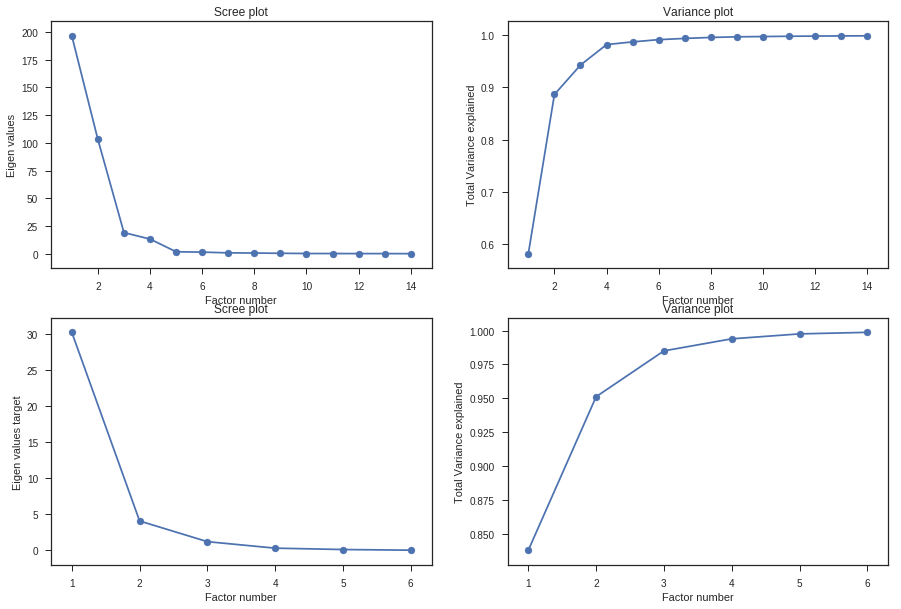

In [9]:
cumsum_var_explained, cumsum_var_explained_target =lib.double_acp_target_feature(X,Y,to_plot=True,nb_factor_max =0.999,nb_factor_max_target = 0.999)

In [0]:
var_feature = 0.999
var_target = 0.999
# Transformation – Standard Scaling of the features & target
sc_features = StandardScaler()
sc_target   = StandardScaler()

X_scaled  = sc_features.fit_transform(X)
Y_scaled  = sc_target.fit_transform(Y)


acp_features = PCA(svd_solver='full',n_components =var_feature)
acp_target = PCA(svd_solver='full',n_components =var_target)
X_orth = acp_features.fit_transform(X_scaled)
Y_orth = acp_target.fit_transform(Y_scaled)

In [0]:
dfX = pd.DataFrame(X_orth[:,:4])
dfY = pd.DataFrame(Y_orth[:,:4])
dfX['label'] = ndarray.astype(label.T,int)

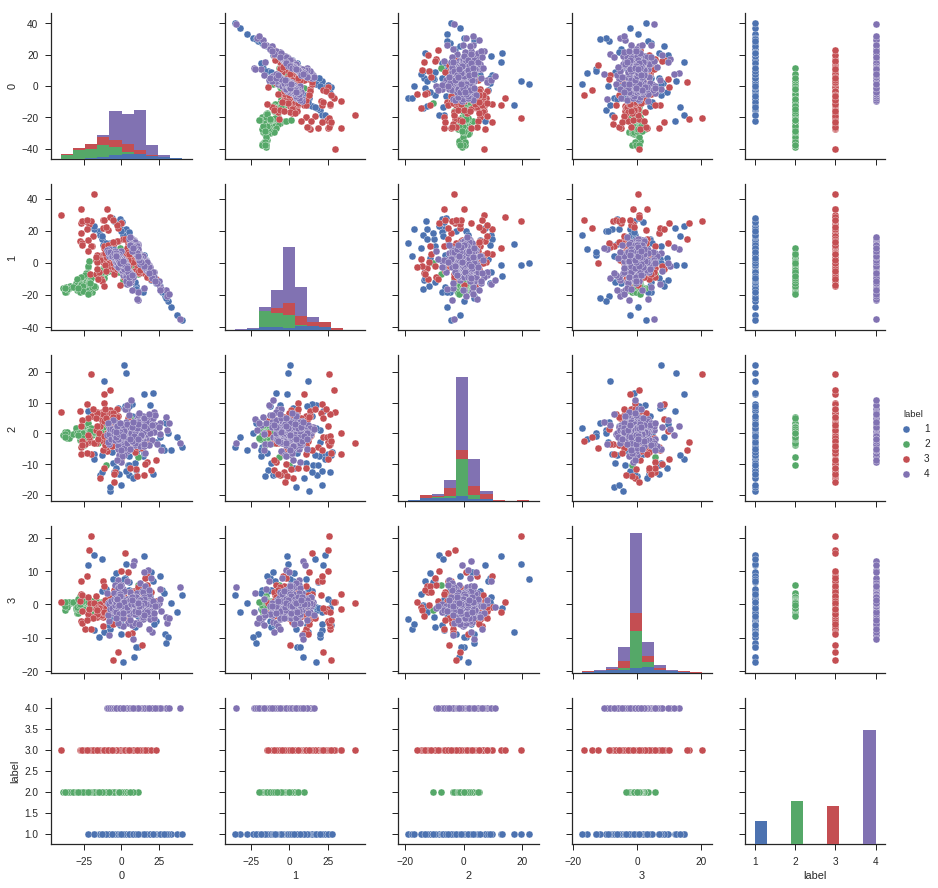

In [139]:
sns.set(style="ticks")
sns.pairplot(dfX, hue="label")

Text(0, 0.5, 'EOF1 Y')

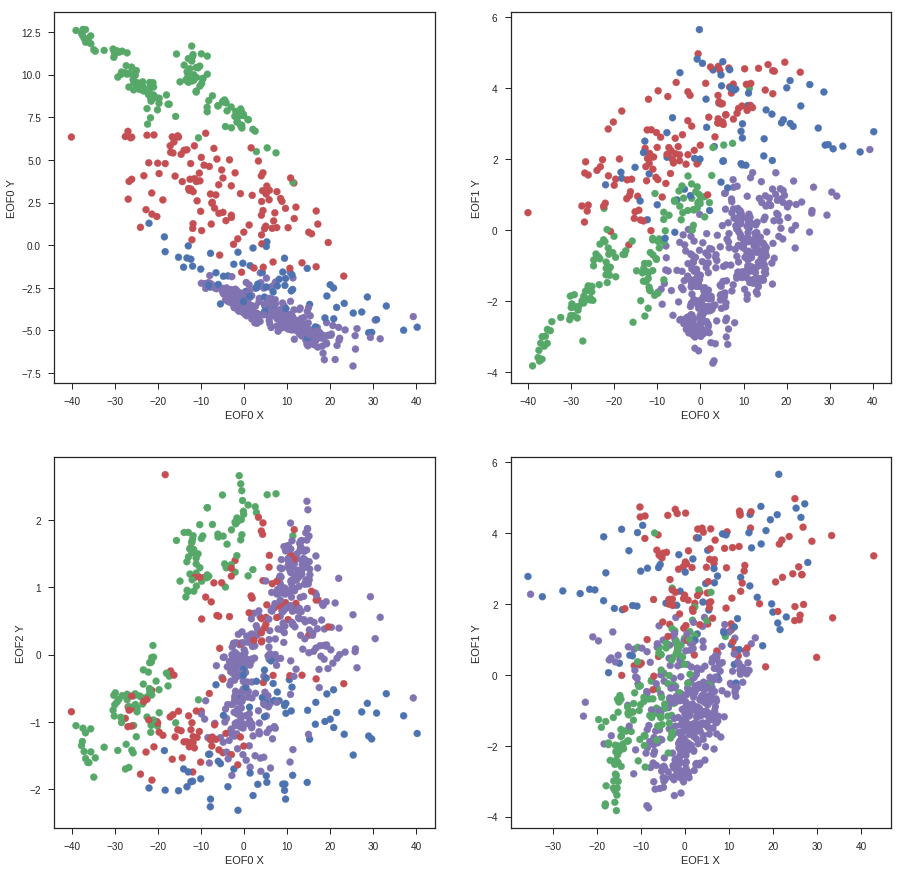

In [12]:
label_int= ndarray.astype(label,int)-1
label_int = np.array(label_int[0])
current_palette = np.array(sns.color_palette())
fig = plt.figure(figsize=(15,15))

ax = plt.subplot(2,2,1)
ax.scatter(dfX[0],dfY[0],c=current_palette[label_int])
ax.set_xlabel('EOF0 X')
ax.set_ylabel('EOF0 Y')

ax2 = plt.subplot(2,2,2)
ax2.scatter(dfX[0],dfY[1],c=current_palette[label_int])
ax2.set_xlabel('EOF0 X')
ax2.set_ylabel('EOF1 Y')

ax3 = plt.subplot(2,2,3)
ax3.scatter(dfX[0],dfY[2],c=current_palette[label_int])
ax3.set_xlabel('EOF0 X')
ax3.set_ylabel('EOF2 Y')

ax4 = plt.subplot(2,2,4)
ax4.scatter(dfX[1],dfY[1],c=current_palette[label_int])
ax4.set_xlabel('EOF1 X')
ax4.set_ylabel('EOF1 Y')


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test,ind_train,ind_test = train_test_split(X, Y,[k for k in range(len(X))],test_size=0.33, random_state=42)

In [0]:
var_feature = 0.999
var_target = 0.999
# Transformation – Standard Scaling of the features & target
sc_features = StandardScaler()
sc_target   = StandardScaler()

X_scaled  = sc_features.fit_transform(X_train)
Y_scaled  = sc_target.fit_transform(y_train)

X_scaled_test  = sc_features.transform(X_test)
Y_scaled_test  = sc_target.transform(y_test)

acp_features = PCA(svd_solver='full',n_components =var_feature)
acp_target = PCA(svd_solver='full',n_components =var_target)

X_orth = acp_features.fit_transform(X_scaled)
Y_orth = acp_target.fit_transform(Y_scaled)

X_orth_test = acp_features.transform(X_scaled_test)
Y_orth_test = acp_target.transform(Y_scaled_test)

## SETTING UP A BASELINE


### Linear Regression model


In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [0]:
class lm_model:
  def __init__(self):
    self.var_feature = None
    self.var_target = None
    self.X_train = None 
    self.y_train = None

  def fit(self):
    var_feature = self.var_feature
    var_target  = self.var_target 
    X_train     = self.X_train  
    y_train     = self.y_train 

    # Transformation – Standard Scaling of the features & target
    sc_features = StandardScaler()
    sc_target   = StandardScaler()

    X_scaled  = sc_features.fit_transform(X_train)
    Y_scaled  = sc_target.fit_transform(y_train)

    acp_features = PCA(svd_solver='full',n_components =var_feature)
    acp_target = PCA(svd_solver='full',n_components =var_target)

    X_orth = acp_features.fit_transform(X_scaled)
    Y_orth = acp_target.fit_transform(Y_scaled)

    clf = LinearRegression()

    clf.fit(X_orth,Y_orth)

    return([clf,acp_features,acp_target,sc_features,sc_target])

  def predict(self,ret_fit, X_test):
    clf = ret_fit[0]
    acp_features = ret_fit[1]
    acp_target = ret_fit[2]
    sc_features = ret_fit[3]
    sc_target = ret_fit[4]

    X_scaled_test  = sc_features.transform(X_test)
    X_orth_test = acp_features.transform(X_scaled_test)

    Y_orth_predicted = clf.predict(X_orth_test)
    Y_scaled_predicted = acp_target.inverse_transform(Y_orth_predicted)
    Y_predicted = sc_target.inverse_transform(Y_scaled_predicted)
    return Y_predicted


#### Linear Regression model 1 

Linear Regression on PCA projected features with 0.999 variance kept

In [0]:
model_linear = lm_model()
model_linear.var_feature = var_feature
model_linear.var_target = var_target
model_linear.X_train = X_train 
model_linear.y_train = y_train
paramModel = model_linear.fit()

In [168]:
Y_predicted = model_linear.predict(paramModel,X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test,Y_predicted))
abs_err  =np.mean(np.abs(y_test-Y_predicted),1)
mae = np.mean(abs_err)

Y_predicted_train = model_linear.predict(paramModel,X_train)
rmse_train = np.sqrt(metrics.mean_squared_error(y_train,Y_predicted_train))
abs_err_train  =np.mean(np.abs(y_train-Y_predicted_train),1)
mae_train = np.mean(abs_err_train)
print("mae_train  ="+str(round(mae_train,2))+"C°")
print("rmse_train ="+str(round(rmse_train,2))+"C°")
print("mae_test   ="+str(round(mae,2))+"C°")
print("rmse_test  ="+str(round(rmse,2))+"C°")

RMS_lab_train = sqrt(mean((Y_predicted_train - y_train)**2,1))
print("RMS_train  = "+str(np.round(np.mean(RMS_lab_train),2))+"C°")
RMS_lab_test = sqrt(mean((Y_predicted - y_test)**2,1))
print("RMS_test   = "+str(np.round(np.mean(RMS_lab_test),2))+"C°")

mae_train  =1.96C°
rmse_train =2.75C°
mae_test   =2.09C°
rmse_test  =2.96C°
RMS_train  = 2.32C°
RMS_test   = 2.47C°


#### Linear Regression model 2

Linear Regression on PCA projected features with 0.99 variance kept

In [0]:
model_linear99 = lm_model()
model_linear99.var_feature = 0.99
model_linear99.var_target = 0.99
model_linear99.X_train = X_train 
model_linear99.y_train = y_train
paramModel99 = model_linear99.fit()

In [167]:
Y_predicted = model_linear99.predict(paramModel99,X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test,Y_predicted))
abs_err  =np.mean(np.abs(y_test-Y_predicted),1)
mae = np.mean(abs_err)

Y_predicted_train = model_linear.predict(paramModel99,X_train)
rmse_train = np.sqrt(metrics.mean_squared_error(y_train,Y_predicted_train))
abs_err_train  =np.mean(np.abs(y_train-Y_predicted_train),1)
mae_train = np.mean(abs_err_train)

print("mae_train  ="+str(round(mae_train,2))+"C°")
print("rmse_train ="+str(round(rmse_train,2))+"C°")
print("mae_test   ="+str(round(mae,2))+"C°")
print("rmse_test  ="+str(round(rmse,2))+"C°")

RMS_lab_train = sqrt(mean((Y_predicted_train - y_train)**2,1))
print("RMS_train  = "+str(np.round(np.mean(RMS_lab_train),2))+"C°")
RMS_lab_test = sqrt(mean((Y_predicted - y_test)**2,1))
print("RMS_test   = "+str(np.round(np.mean(RMS_lab_test),2))+"C°")

mae_train  =2.12C°
rmse_train =2.93C°
mae_test   =2.23C°
rmse_test  =3.15C°
RMS_train  = 2.49C°
RMS_test   = 2.63C°


#### Visualize some results

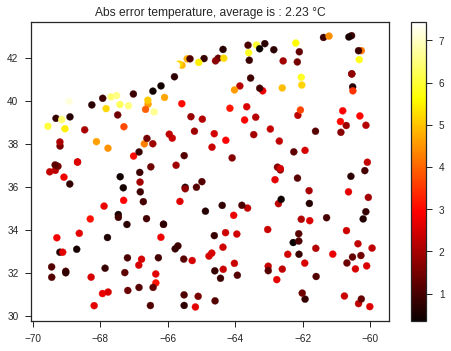

In [149]:
fig,ax= plt.subplots()
CS3 =scatter(lon[ind_test],lat[ind_test],c=abs_err,cmap=plt.cm.hot)
title("Abs error temperature, average is : "+str(round(mae,2))+" °C")
plt.colorbar(CS3)
plt.show()

###EM - Kmeans model


In [0]:
class KmeansModel:
  def __init__(self):
    self.var_feature = None
    self.var_target = None
    self.X_train = None 
    self.y_train = None
    self.K       = None
    self.iter_EM = None

  def temperature_profile(self,X_orth,Beta_hat,label):
    """
    return the targeted temperature profile using features and linear coefficients 
    with : X_orth surface observation
           Beta_hat : Regression coefficient
           label:  label of the sample observed
    """
    output = np.array([X_orth[l,:]@Beta_hat[label[l],:,:] for l in range(len(label))])
    return(output)
  
  def fit(self):
    var_feature = self.var_feature
    var_target  = self.var_target 
    X_train     = self.X_train  
    y_train     = self.y_train
    K           = self.K
    iter_EM     = self.iter_EM


    # Transformation – Standard Scaling of the features & target
    sc_features = StandardScaler()
    sc_target   = StandardScaler()

    X_scaled  = sc_features.fit_transform(X_train)
    Y_scaled  = sc_target.fit_transform(y_train)

    acp_features = PCA(svd_solver='full',n_components =self.var_feature)
    acp_target = PCA(svd_solver='full',n_components =self.var_target)

    X_orth = acp_features.fit_transform(X_scaled)
    Y_orth = acp_target.fit_transform(Y_scaled)
    method = "kmeans"
    
    lambda_init,Beta_init,Sigma_init = lib.init_EM_latent_class_regression(X_orth,Y_orth,K,method)
    log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat=lib.EM_latent_class_regression(X_orth,Y_orth,lambda_init,Beta_init,Sigma_init,iter_EM)

    fig, axes = plt.subplots(1,2)
    axes[0].plot(log_lik)
    axes[0].set_title('Log_lik curve to assert convergence')
    axes[0].set_xlabel('Iteration EM algorithm')
    axes[0].set_ylabel('Log Likelihood')
    # From pi_hat we hardcode the label 
    label_pred = ndarray.astype(np.argmax(pi_hat,1),int)
    probability_density = zeros((len(X_orth),K))
    multivariate_normal_law=[]
    for label in range(K):   
        ind_label = find(label_pred==label)
        mean_ = mean(X_orth[ind_label,:],0)
        cov_  = cov(X_orth[ind_label,:].T)
        axes[1].plot(mean_)
        for k in range(len(X_orth)):
            probability_density[k,label]= multivariate_normal.pdf(X_orth[k,:], mean=mean_, cov=cov_)
        multivariate_normal_law.append(multivariate_normal(mean=mean_, cov=cov_))
    
    axes[1].set_title('Visualization of Gaussian mean')
    axes[1].set_xlabel('n th component of PCA')
    return([K,acp_features,acp_target,sc_features,sc_target,multivariate_normal_law,Beta_hat])

  def predict(self,ret_fit, X_test):
    K               = ret_fit[0]
    acp_features    = ret_fit[1]
    acp_target      = ret_fit[2]
    sc_features     = ret_fit[3]
    sc_target       = ret_fit[4]
    multivariate_normal_law = ret_fit[5]
    Beta_hat = ret_fit[6]
    
    X_scaled_test  = sc_features.transform(X_test)
    #     print('X_test.shape',X_test.shape)
    X_orth_test = acp_features.transform(X_scaled_test)
    #     print('X_test.shape',X_test.shape)
    probability_density_test = zeros((len(X_orth_test),K))
    for label in range(K):   
        for k in range(len(X_orth_test)):
            probability_density_test[k,label]= multivariate_normal_law[label].pdf(X_orth_test[k,:])
    label_attributed_test = np.argmax(probability_density_test,1)
    
    temp_pred_lab_test = self.temperature_profile(X_orth_test,Beta_hat,label_attributed_test)

    # ACP inverse
    temp_true_profile = acp_target.inverse_transform(temp_pred_lab_test) 

    # Rescaling
    rescale_temp =sc_target.inverse_transform(temp_true_profile) 
    return rescale_temp


#### EM - Kmeans model 1

EM - Kmeans K=4 on PCA projected features with variance kept =0.999

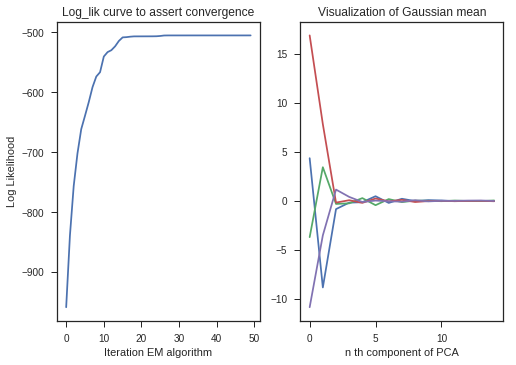

In [151]:
model_kmeans_4 = KmeansModel()

model_kmeans_4.var_feature  = var_feature
model_kmeans_4.var_target   = var_target
model_kmeans_4.X_train      = X_train 
model_kmeans_4.y_train      = y_train
model_kmeans_4.K            = 4
model_kmeans_4.iter_EM      = 50

paramModel_kmeans = model_kmeans_4.fit()

mae_train  = 1.54C°
rmse_train = 2.39C°
mae_test   = 1.85C°
rmse_test  = 2.88C°
RMS_train  = 1.84C°
RMS_test   = 2.21C°


Text(0.5, 0, 'Absolute err in °C')

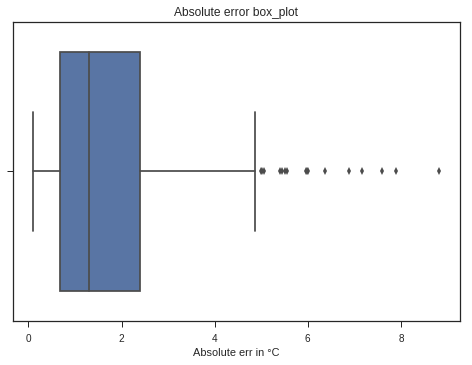

In [166]:
Y_predicted = model_kmeans_4.predict(paramModel_kmeans,X_test)
rmse        = np.sqrt(metrics.mean_squared_error(y_test,Y_predicted))
abs_err     = np.mean(np.abs(y_test-Y_predicted),1)
mae         = np.mean(abs_err)

Y_predicted_train = model_kmeans_4.predict(paramModel_kmeans,X_train)
rmse_train        = np.sqrt(metrics.mean_squared_error(y_train,Y_predicted_train))
abs_err_train     = np.mean(np.abs(y_train-Y_predicted_train),1)
mae_train         = np.mean(abs_err_train)

print("mae_train  = " + str(round(mae_train,2))+"C°")
print("rmse_train = " + str(round(rmse_train,2))+"C°")
print("mae_test   = " + str(round(mae,2))+"C°")
print("rmse_test  = " + str(round(rmse,2))+"C°")

RMS_lab_train = sqrt(mean((Y_predicted_train - y_train)**2,1))
print("RMS_train  = "+str(np.round(np.mean(RMS_lab_train),2))+"C°")
RMS_lab_test = sqrt(mean((Y_predicted - y_test)**2,1))
print("RMS_test   = "+str(np.round(np.mean(RMS_lab_test),2))+"C°")

sns.boxplot(abs_err)
plt.title('Absolute error box_plot')
plt.xlabel('Absolute err in °C')

#### EM - Kmeans model 2

EM - Kmeans K=4 on PCA projected features with variance kept =0.99

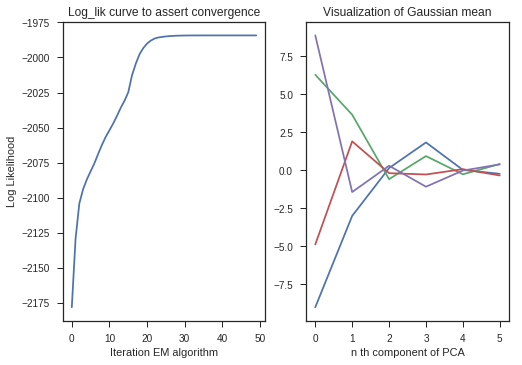

In [169]:
model_kmeans_4_99 = KmeansModel()

model_kmeans_4_99.var_feature  = 0.99
model_kmeans_4_99.var_target   = 0.99
model_kmeans_4_99.X_train      = X_train 
model_kmeans_4_99.y_train      = y_train
model_kmeans_4_99.K            = 4
model_kmeans_4_99.iter_EM      = 50

paramModel_kmeans_99 = model_kmeans_4_99.fit()


mae_train  = 2.06C°
rmse_train = 3.3C°
mae_test   = 2.28C°
rmse_test  = 3.53C°
RMS_train  = 2.41C°
RMS_test   = 2.69C°


Text(0.5, 0, 'Absolute err in °C')

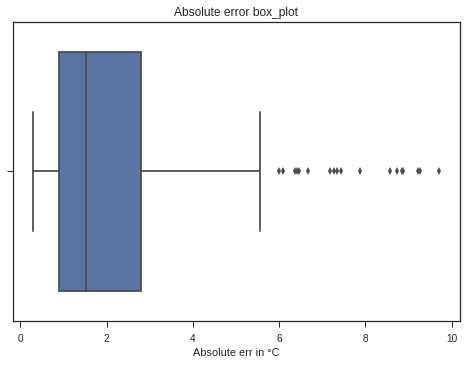

In [171]:
Y_predicted = model_kmeans_4_99.predict(paramModel_kmeans_99,X_test)
rmse        = np.sqrt(metrics.mean_squared_error(y_test,Y_predicted))
abs_err     = np.mean(np.abs(y_test-Y_predicted),1)
mae         = np.mean(abs_err)

Y_predicted_train = model_kmeans_4_99.predict(paramModel_kmeans_99,X_train)
rmse_train        = np.sqrt(metrics.mean_squared_error(y_train,Y_predicted_train))
abs_err_train     = np.mean(np.abs(y_train-Y_predicted_train),1)
mae_train         = np.mean(abs_err_train)

print("mae_train  = " + str(round(mae_train,2))+"C°")
print("rmse_train = " + str(round(rmse_train,2))+"C°")
print("mae_test   = " + str(round(mae,2))+"C°")
print("rmse_test  = " + str(round(rmse,2))+"C°")

RMS_lab_train = sqrt(mean((Y_predicted_train - y_train)**2,1))
print("RMS_train  = "+str(np.round(np.mean(RMS_lab_train),2))+"C°")
RMS_lab_test = sqrt(mean((Y_predicted - y_test)**2,1))
print("RMS_test   = "+str(np.round(np.mean(RMS_lab_test),2))+"C°")

sns.boxplot(abs_err)
plt.title('Absolute error box_plot')
plt.xlabel('Absolute err in °C')

#### EM - Kmeans model 3

EM - Kmeans K= 3 on PCA projected features with variance kept =0.99

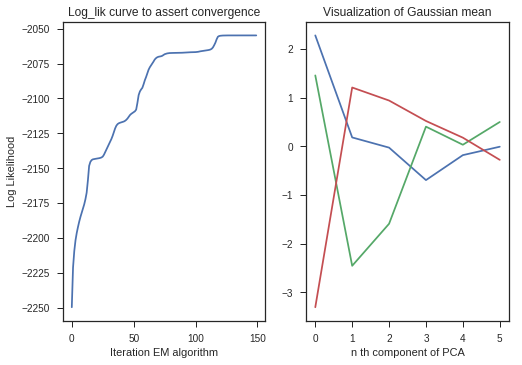

In [172]:
model_kmeans_3_99 = KmeansModel()

model_kmeans_3_99.var_feature = 0.99
model_kmeans_3_99.var_target  = 0.99
model_kmeans_3_99.X_train     = X_train 
model_kmeans_3_99.y_train     = y_train
model_kmeans_3_99.K           = 3
model_kmeans_3_99.iter_EM     = 150

paramModel_kmeans_3_99 = model_kmeans_3_99.fit()

mae_train  = 1.93C°
rmse_train = 2.85C°
mae_test   = 2.03C°
rmse_test  = 3.0C°
RMS_train  = 2.26C°
RMS_test   = 2.38C°


Text(0.5, 0, 'Absolute err in °C')

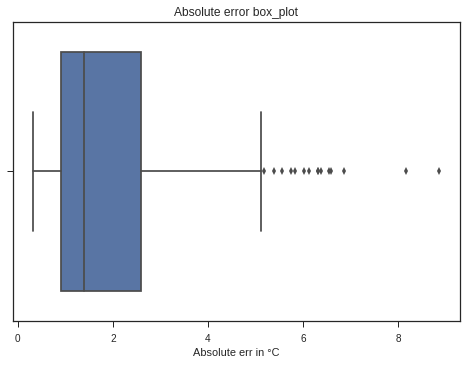

In [173]:
Y_predicted = model_kmeans_3_99.predict(paramModel_kmeans_3_99,X_test)
rmse        = np.sqrt(metrics.mean_squared_error(y_test,Y_predicted))
abs_err     = np.mean(np.abs(y_test-Y_predicted),1)
mae         = np.mean(abs_err)

Y_predicted_train = model_kmeans_3_99.predict(paramModel_kmeans_3_99,X_train)
rmse_train        = np.sqrt(metrics.mean_squared_error(y_train,Y_predicted_train))
abs_err_train     = np.mean(np.abs(y_train-Y_predicted_train),1)
mae_train         = np.mean(abs_err_train)

print("mae_train  = " + str(round(mae_train,2))+"C°")
print("rmse_train = " + str(round(rmse_train,2))+"C°")
print("mae_test   = " + str(round(mae,2))+"C°")
print("rmse_test  = " + str(round(rmse,2))+"C°")

RMS_lab_train = sqrt(mean((Y_predicted_train - y_train)**2,1))
print("RMS_train  = "+str(np.round(np.mean(RMS_lab_train),2))+"C°")
RMS_lab_test = sqrt(mean((Y_predicted - y_test)**2,1))
print("RMS_test   = "+str(np.round(np.mean(RMS_lab_test),2))+"C°")

sns.boxplot(abs_err)
plt.title('Absolute error box_plot')
plt.xlabel('Absolute err in °C')

#### EM - Kmeans model 4

EM - Kmeans K= 3 on PCA projected features with variance kept =0.999

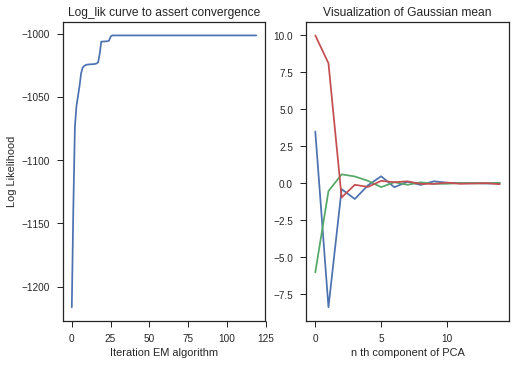

In [174]:
model_kmeans_3 = KmeansModel()
model_kmeans_3.var_feature = var_feature
model_kmeans_3.var_target  = var_target
model_kmeans_3.X_train     = X_train 
model_kmeans_3.y_train     = y_train
model_kmeans_3.K           = 3
model_kmeans_3.iter_EM     = 120

paramModel_kmeans_3 = model_kmeans_3.fit()

mae_train  = 1.65C°
rmse_train = 2.51C°
mae_test   = 1.96C°
rmse_test  = 2.99C°
RMS_train  = 1.97C°
RMS_test   = 2.33C°


Text(0.5, 0, 'Absolute err in °C')

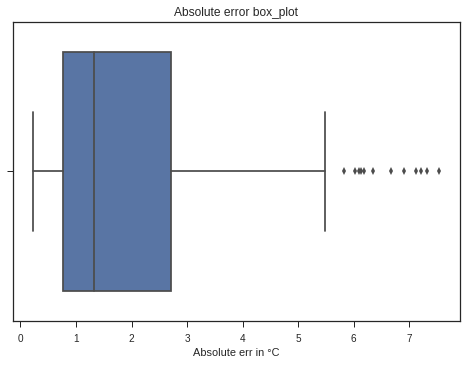

In [175]:
Y_predicted = model_kmeans_3.predict(paramModel_kmeans_3,X_test)
rmse        = np.sqrt(metrics.mean_squared_error(y_test,Y_predicted))
abs_err     = np.mean(np.abs(y_test-Y_predicted),1)
mae         = np.mean(abs_err)

Y_predicted_train = model_kmeans_3.predict(paramModel_kmeans_3,X_train)
rmse_train        = np.sqrt(metrics.mean_squared_error(y_train,Y_predicted_train))
abs_err_train     = np.mean(np.abs(y_train-Y_predicted_train),1)
mae_train         = np.mean(abs_err_train)

print("mae_train  = " + str(round(mae_train,2))+"C°")
print("rmse_train = " + str(round(rmse_train,2))+"C°")
print("mae_test   = " + str(round(mae,2))+"C°")
print("rmse_test  = " + str(round(rmse,2))+"C°")

RMS_lab_train = sqrt(mean((Y_predicted_train - y_train)**2,1))
print("RMS_train  = "+str(np.round(np.mean(RMS_lab_train),2))+"C°")
RMS_lab_test = sqrt(mean((Y_predicted - y_test)**2,1))
print("RMS_test   = "+str(np.round(np.mean(RMS_lab_test),2))+"C°")


sns.boxplot(abs_err)
plt.title('Absolute error box_plot')
plt.xlabel('Absolute err in °C')

#### Some Qualitative observations  EM-Kmeans model 1


assignment matrix [[0 2]
 [1 3]
 [2 1]
 [3 0]]
confusion_matrice = 
[[0.14814815 0.         0.37037037 0.48148148]
 [0.01149425 0.98850575 0.         0.        ]
 [0.025      0.075      0.8875     0.0125    ]
 [0.45238095 0.         0.01587302 0.53174603]]
accuracy= 0.6321353065539113


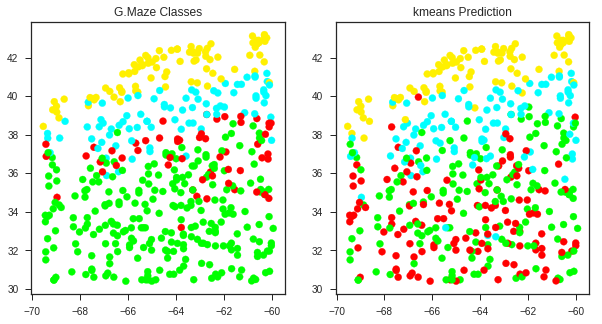

In [16]:
K= 4
nb_class=K
iter_EM=30
method ="kmeans"
gt_label=ndarray.astype(label[0,ind_train]-1,int)
color=["#FF0000","#FFF000","#00FFFF","#00FF00"]
# color= current_palette
real_color = [color[gt_label[k]] for k in range(len(gt_label))]

# Run EM-Kmeans model 1

lambda_init,Beta_init,Sigma_init = lib.init_EM_latent_class_regression(X_orth,Y_orth,K,method)
log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat=lib.EM_latent_class_regression(X_orth,Y_orth,lambda_init,Beta_init,Sigma_init,iter_EM)
kmeans_index_class =ndarray.astype(np.argmax(pi_hat,1),int)
rpz_kmeans_class = zeros((nb_class,Y_orth.shape[1]))
ground_truth_rpz_class= zeros((nb_class,Y_orth.shape[1]))
for k in range(nb_class):
    ground_truth_rpz_class[k,:] = np.mean(Y_orth[np.where(gt_label==k),:].squeeze(),0)
    rpz_kmeans_class[k,:] = np.mean(Y_orth[np.where(np.array(kmeans_index_class)==k),:].squeeze(),0)

# Assignment between kmeans and ground truth
distance_matrix    = array([[np.linalg.norm(ground_truth_rpz_class[i,:]-rpz_kmeans_class[j,:]) for i in range(nb_class)] for j in range(nb_class)])                      
assignment_matrix = la.linear_assignment(distance_matrix)
new_kmeans_class = zeros(len(kmeans_index_class))
for k in range(nb_class):
    new_kmeans_class[np.where(np.array(kmeans_index_class)==k)]= assignment_matrix[k][1]

new_kmeans_class = ndarray.astype(new_kmeans_class,int)
color_kmeans = [color[new_kmeans_class[k]] for k in range(len(new_kmeans_class))]

print("assignment matrix",assignment_matrix)  
figure,ax = subplots(figsize=(10,5))
subplot(121)
scatter(lon[ind_train],lat[ind_train],color=real_color)
title("G.Maze Classes")
subplot(122)
scatter(lon[ind_train],lat[ind_train],color=color_kmeans)
title("kmeans Prediction")

from sklearn.metrics import confusion_matrix
y_true = gt_label
y_pred = new_kmeans_class
conf_mat = confusion_matrix(y_true, y_pred)

norm_confusion_mat = array([conf_mat[k] / sum(conf_mat[k]) for k in range(len(conf_mat))])
print("confusion_matrice = ")
print(norm_confusion_mat)

accurate_assignment= len(find([y_true[k]==y_pred[k] for k in range(len(y_true))]))
accuracy = accurate_assignment/len(y_true)
print("accuracy=",accuracy)

In [0]:
# From pi_hat we hardcode the label 
label_pred = ndarray.astype(np.argmax(pi_hat,1),int)

probability_density = zeros((len(X_orth),4))
multivariate_normal_law=[]
for label in range(4):   
    ind_label = find(label_pred==label)
    mean_ = mean(X_orth[ind_label,:],0)
    cov_  = cov(X_orth[ind_label,:].T)
    for k in range(len(X_orth)):
        probability_density[k,label]= multivariate_normal.pdf(X_orth[k,:], mean=mean_, cov=cov_)
    multivariate_normal_law.append(multivariate_normal(mean=mean_, cov=cov_))

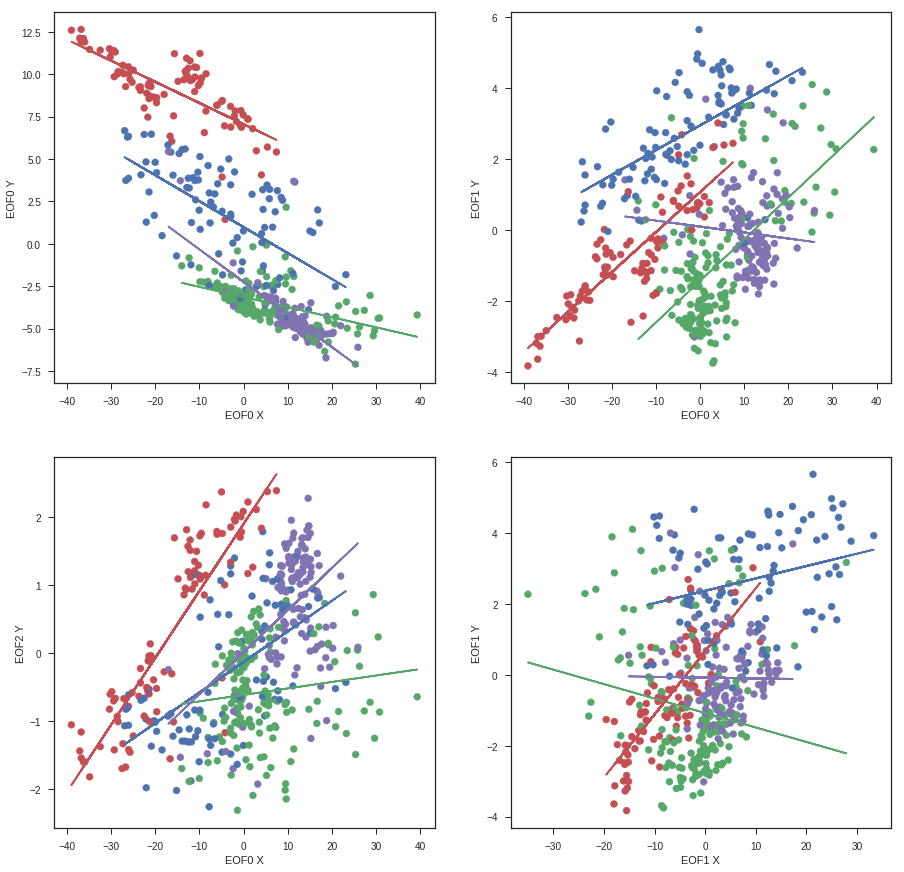

In [80]:
label_int = np.array(label_pred)
current_palette = np.array(sns.color_palette())
fig = plt.figure(figsize=(15,15))

ax = plt.subplot(2,2,1)
ax.scatter(dfX[0][ind_train],dfY[0][ind_train],c=current_palette[label_int])

for ck in range(4):
  clf_ =  LinearRegression()
  clf_.fit(dfX[0][ind_train][label_int==ck].reshape(-1,1),dfY[0][ind_train][label_int==ck].reshape(-1,1))
  Y_pred = clf_.predict(dfX[0][ind_train][label_int==ck].values.reshape(-1,1))
  ax.plot(dfX[0][ind_train][label_int==ck],Y_pred,c=current_palette[ck])


ax.set_xlabel('EOF0 X')
ax.set_ylabel('EOF0 Y')

ax2 = plt.subplot(2,2,2)
ax2.scatter(dfX[0][ind_train],dfY[1][ind_train],c=current_palette[label_int])
ax2.set_xlabel('EOF0 X')
ax2.set_ylabel('EOF1 Y')

for ck in range(4):
  clf_ =  LinearRegression()
  clf_.fit(dfX[0][ind_train][label_int==ck].reshape(-1,1),dfY[1][ind_train][label_int==ck].reshape(-1,1))
  Y_pred = clf_.predict(dfX[0][ind_train][label_int==ck].values.reshape(-1,1))
  ax2.plot(dfX[0][ind_train][label_int==ck],Y_pred,c=current_palette[ck])



ax3 = plt.subplot(2,2,3)
ax3.scatter(dfX[0][ind_train],dfY[2][ind_train],c=current_palette[label_int])
ax3.set_xlabel('EOF0 X')
ax3.set_ylabel('EOF2 Y')


for ck in range(4):
  clf_ =  LinearRegression()
  clf_.fit(dfX[0][ind_train][label_int==ck].reshape(-1,1),dfY[2][ind_train][label_int==ck].reshape(-1,1))
  Y_pred = clf_.predict(dfX[0][ind_train][label_int==ck].values.reshape(-1,1))
  ax3.plot(dfX[0][ind_train][label_int==ck],Y_pred,c=current_palette[ck])



ax4 = plt.subplot(2,2,4)
ax4.scatter(dfX[1][ind_train],dfY[1][ind_train],c=current_palette[label_int])
ax4.set_xlabel('EOF1 X')
ax4.set_ylabel('EOF1 Y')

for ck in range(4):
  clf_ =  LinearRegression()
  clf_.fit(dfX[1][ind_train][label_int==ck].reshape(-1,1),dfY[1][ind_train][label_int==ck].reshape(-1,1))
  Y_pred = clf_.predict(dfX[1][ind_train][label_int==ck].values.reshape(-1,1))
  ax4.plot(dfX[1][ind_train][label_int==ck],Y_pred,c=current_palette[ck])



In [25]:
Beta_hat.shape

(4, 15, 7)

In [0]:
def temperature_profile(X_orth,Beta_hat,label):
    """
    return the targeted temperature profile using features and linear coefficients 
    with : X_orth surface observation
           Beta_hat : Regression coefficient
           label:  label of the sample observed
    """
    output = np.array([X_orth[l,:]@Beta_hat[label[l],:,:] for l in range(len(label))])
    return(output)

In [180]:
label_attributed = np.argmax(probability_density,1)
ratio_good_assignment= len(find(label_attributed==label_pred))/len(label_attributed)

print("Good assignment ratio on training : ",np.round(ratio_good_assignment,3))
temp_pred_lab = temperature_profile(X_orth,Beta_hat,label_attributed)

# ACP inverse
temp_true_profile = acp_target.inverse_transform(temp_pred_lab) 

# Rescaling
rescale_temp =sc_target.inverse_transform(temp_true_profile) 


# Compute the error RMS
RMSE = np.sqrt(metrics.mean_squared_error(rescale_temp,temp[ind_train])) 
RMS_lab = sqrt(mean((rescale_temp - temp[ind_train])**2,1))

#Compute MAE
MAE =np.mean(np.abs(rescale_temp - temp[ind_train,:]))

Good assignment ratio on training :  0.869


MAE = 1.54°C
RMSE = 2.39°C
min(RMS) =  0.22°C
max(RMS) = 9.2°C


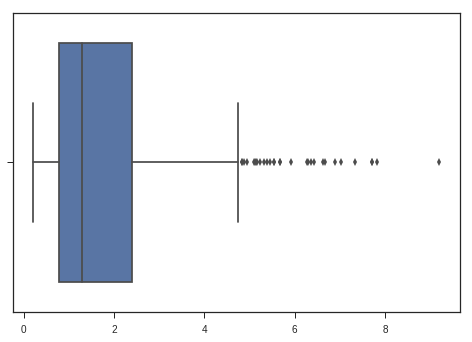

In [181]:
print("MAE = "+str(round(MAE,2)) +"°C")
print("RMSE = "+str(round(RMSE,2)) +"°C")
print("min(RMS) =  "+str(round(min(RMS_lab),2)) +"°C")
print("max(RMS) = "+str(round(max(RMS_lab),2)) +"°C")

sns.boxplot(RMS_lab)

Assignment ratio on testing

mean(RMSE) = 2.21°C
min(RMSE) =  0.17°C
max(RMSE) = 9.93°C
MAE = 1.86°C


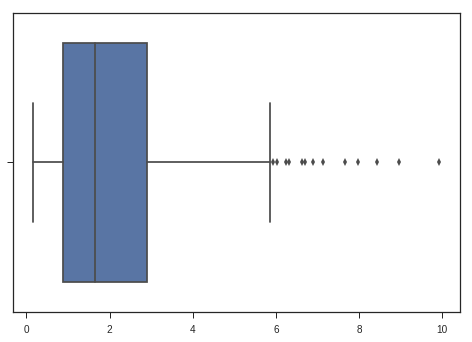

In [0]:
probability_density_test = zeros((len(X_orth_test),4))
for label in range(4):   
    for k in range(len(X_orth_test)):
        probability_density_test[k,label]= multivariate_normal_law[label].pdf(X_orth_test[k,:])
        
label_attributed_test = np.argmax(probability_density_test,1)
temp_pred_lab_test = temperature_profile(X_orth_test,Beta_hat,label_attributed_test)

# ACP inverse
temp_true_profile = acp_target.inverse_transform(temp_pred_lab_test) 

# Rescaling
rescale_temp =sc_target.inverse_transform(temp_true_profile) 


# Compute the error RMS
RMS_lab = sqrt(mean((rescale_temp - temp[ind_test])**2,1))

RMSE = np.sqrt(metrics.mean_squared_error(rescale_temp,temp[ind_test])) 

#Compute MAE
MAE =np.mean(np.abs(rescale_temp - temp[ind_test,:]))


print("RMSE = "+str(round(RMSE,2)) +"°C")
print("min(RMSE) =  "+str(round(min(RMS_lab),2)) +"°C")
print("max(RMSE) = "+str(round(max(RMS_lab),2)) +"°C")

print("MAE = "+str(round(MAE,2)) +"°C")

sns.boxplot(RMS_lab)

#### Some Qualitative observations  EM-Kmeans model 4


[[0 2]
 [1 3]
 [2 1]
 [3 0]]


Text(0.5, 1.0, 'Kmeans Prediction')

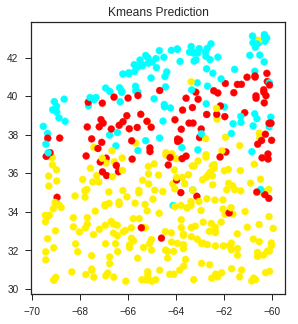

In [0]:
K= 3
iter_EM=120
method ="kmeans"
lambda_init,Beta_init,Sigma_init = lib.init_EM_latent_class_regression(X_orth,Y_orth,K,method)
log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat=lib.EM_latent_class_regression(X_orth,Y_orth,lambda_init,Beta_init,Sigma_init,iter_EM)
kmeans_index_class =ndarray.astype(np.argmax(pi_hat,1),int)

color_kmeans = [color[kmeans_index_class[k]] for k in range(len(new_kmeans_class))]

print(assignment_matrix)  
figure,ax = subplots(figsize=(10,5))
subplot(122)
scatter(lon[ind_train],lat[ind_train],color=color_kmeans)
title("Kmeans Prediction")

Text(0, 0.5, 'Log Likelihood')

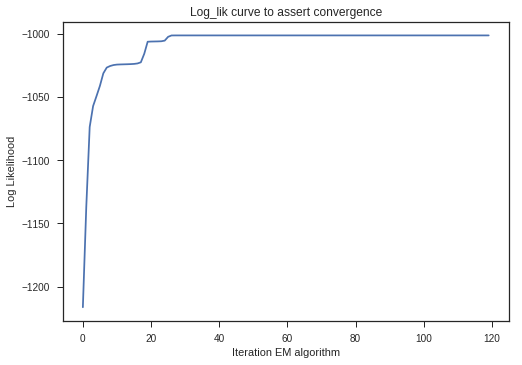

In [0]:
fig, ax = plt.subplots()
ax.plot(log_lik)
ax.set_title('Log_lik curve to assert convergence')
ax.set_xlabel('Iteration EM algorithm')
ax.set_ylabel('Log Likelihood')

In [0]:
# From pi_hat we hardcode the label 
label_pred = ndarray.astype(np.argmax(pi_hat,1),int)

probability_density = zeros((len(X_orth),K))
multivariate_normal_law=[]
for label in range(K):
    ind_label = find(label_pred==label)
    cov_  = cov(X_orth[ind_label,:].T)
    mean_ = mean(X_orth[ind_label,:],0)
    for k in range(len(X_orth)):
        probability_density[k,label]= multivariate_normal.pdf(X_orth[k,:], mean=mean_, cov=cov_)
    multivariate_normal_law.append(multivariate_normal(mean=mean_, cov=cov_))

Good assignment ratio on training :  0.825
RMSE      = 2.51°C
min(RMSE) = 0.23°C
max(RMSE) = 8.65°C
MAE       = 1.65°C


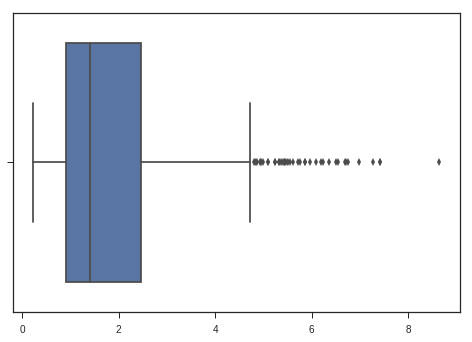

In [0]:
label_attributed = np.argmax(probability_density,1)
ratio_good_assignment= len(find(label_attributed==label_pred))/len(label_attributed)

print("Good assignment ratio on training : ",np.round(ratio_good_assignment,3))
temp_pred_lab = temperature_profile(X_orth,Beta_hat,label_attributed)

# ACP inverse
temp_true_profile = acp_target.inverse_transform(temp_pred_lab) 

# Rescaling
rescale_temp =sc_target.inverse_transform(temp_true_profile) 


# Compute the error RMS
RMS_lab = sqrt(mean((rescale_temp - temp[ind_train])**2,1))

RMSE = np.sqrt(metrics.mean_squared_error(rescale_temp,temp[ind_train])) 

#Compute MAE
MAE =np.mean(np.abs(rescale_temp - temp[ind_train,:]))

print("RMSE      = "+str(round(RMSE,2)) +"°C")
print("min(RMSE) = "+str(round(min(RMS_lab),2)) +"°C")
print("max(RMSE) = "+str(round(max(RMS_lab),2)) +"°C")

print("MAE       = "+str(round(MAE,2)) +"°C")

sns.boxplot(RMS_lab)

RMSE      = 2.99°C
min(RMSE) = 0.28°C
max(RMSE) = 8.55°C
MAE       = 1.96°C


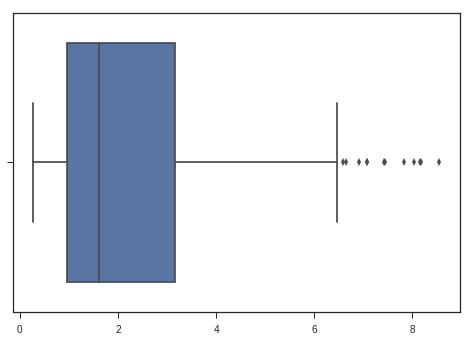

In [0]:
probability_density_test = zeros((len(X_orth_test),K))
for label in range(K):   
    for k in range(len(X_orth_test)):
        probability_density_test[k,label]= multivariate_normal_law[label].pdf(X_orth_test[k,:])
label_attributed_test = np.argmax(probability_density_test,1)
temp_pred_lab_test = temperature_profile(X_orth_test,Beta_hat,label_attributed_test)

# ACP inverse
temp_true_profile = acp_target.inverse_transform(temp_pred_lab_test) 

# Rescaling
rescale_temp =sc_target.inverse_transform(temp_true_profile) 


# Compute the error RMS
RMS_lab = sqrt(mean((rescale_temp - temp[ind_test])**2,1))

# COMPUTE RMSE
RMSE = np.sqrt(metrics.mean_squared_error(rescale_temp,temp[ind_test])) 

#Compute MAE
MAE =np.mean(np.abs(rescale_temp - temp[ind_test,:]))


print("RMSE      = "+str(round(RMSE,2)) +"°C")
print("min(RMSE) = "+str(round(min(RMS_lab),2)) +"°C")
print("max(RMSE) = "+str(round(max(RMS_lab),2)) +"°C")

print("MAE       = "+str(round(MAE,2)) +"°C")

sns.boxplot(RMS_lab)

### CNN MODEL

Let's build our own model using the following CNN architecture:

1.  **Convolutional Layer #1**: Applies 32 7x7 filters (extracting 7x7-pixel
    subregions), with ReLU activation function
1.  **2nd Convolutional Layer #1**: Applies 32 7x7 filters (extracting 7x7-pixel
subregions), with ReLU activation function

2.  **Pooling Layer #1**: Performs max pooling with a 2x2 filter and stride of 2
    (which specifies that pooled regions do not overlap)
    
3.  **Convolutional Layer #2**: Applies 64 3x3 filters, with ReLU activation
    function
3.  **2nd Convolutional Layer #2**: Applies 64 3x3 filters, with ReLU activation
    function
4.  **Pooling Layer #2**: Again, performs max pooling with a 2x2 filter and
    stride of 2
    
5.  **flatten Layer #1**
    
6. **Dense Layer #1** : (Regression Layer) : 36 neurons, one for each dimension of the target.

In [206]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
sla = ds['SLA'].isel().values
sst = ds['SST'].isel().values
features = np.zeros((sla.shape[0],sla.shape[1],sla.shape[2],2))
features[:,:,:,0] =sla
features[:,:,:,1] =sst

#### Preprocessing 

In [0]:
features = lib.replace_nan(features)

In [0]:
X_train_cnn = features[ind_train,:,:,:]
y_train_cnn = y_train

X_test_cnn = features[ind_test,:,:,:]
y_test_cnn = y_test


sc_features_cnn = StandardScaler()

X_scaled_cnn  = sc_features_cnn.fit_transform(X_train_cnn.reshape(len(y_train),13*13*2)).reshape(len(y_train),13,13,2)
X_test_scaled_cnn =  sc_features_cnn.transform(X_test_cnn.reshape(len(y_test),13*13*2)).reshape(len(y_test),13,13,2)

#### Create and Build CNN

In [0]:
def create_model():
  input_shape = (13,13,2)
  model = Sequential()
  model.add(Conv2D(filters = 32, kernel_size = (7,7),padding = 'Same', 
                   activation ='relu', input_shape = input_shape))
  model.add(Conv2D(filters = 32, kernel_size = (7,7),padding = 'Same', 
                   activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.1))

  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                   activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                   activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.1))

  model.add(Flatten())
  model.add(Dense(36))
  return(model)

In [0]:
model = create_model()

In [0]:
# For a mean squared error regression problem
model.compile(optimizer='adam',
              loss='mse')



#### Train CNN

In [0]:
# !rm -rf /content/checkpoints/
# !mkdir /content/checkpoints/
# checkpoint
filepath="/content/checkpoints/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

# Fit the model
history = model.fit(X_train_cnn, y_train_cnn,
          batch_size=64,
          epochs=500,
          verbose=1,
          validation_data=(X_test_cnn, y_test_cnn),
          callbacks=callbacks_list)

Train on 473 samples, validate on 233 samples
Epoch 1/500
473/473 [==============================] - 4s 10ms/step - loss: 142.1782 - val_loss: 33.8632

Epoch 00001: val_loss improved from inf to 33.86318, saving model to /content/checkpoints/weights-improvement-01-33.86.hdf5
Epoch 2/500
473/473 [==============================] - 1s 3ms/step - loss: 32.4914 - val_loss: 18.7034

Epoch 00002: val_loss improved from 33.86318 to 18.70337, saving model to /content/checkpoints/weights-improvement-02-18.70.hdf5
Epoch 3/500
473/473 [==============================] - 1s 3ms/step - loss: 17.6070 - val_loss: 17.3930

Epoch 00003: val_loss improved from 18.70337 to 17.39295, saving model to /content/checkpoints/weights-improvement-03-17.39.hdf5
Epoch 4/500
473/473 [==============================] - 1s 3ms/step - loss: 16.0800 - val_loss: 16.9088

Epoch 00004: val_loss improved from 17.39295 to 16.90883, saving model to /content/checkpoints/weights-improvement-04-16.91.hdf5
Epoch 5/500
473/473 [====

(0, 30)

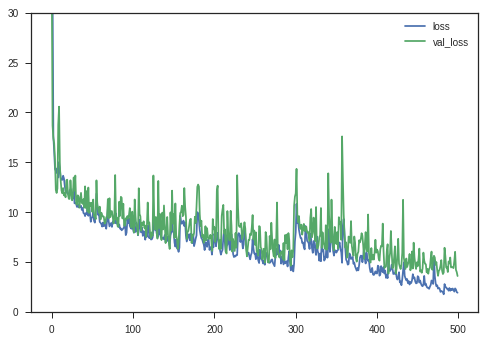

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.ylim(0,30)

In [0]:
np.sqrt(metrics.mean_squared_error(model.predict(X_test_cnn),y_test_cnn))

1.8950704423098992

In [0]:
#!zip -r checkpoints.zip /content/checkpoints
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp /content/checkpoints.zip /content/gdrive/My\ Drive/OceanographyProject/checkpoints.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#### LOAD CNN



In [208]:
# Load Checkpoints
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1lleyOv1V2CpFQIXxuPUeAQEdSkDKfEbd',dest_path= '/content/checkpoints.zip',unzip=False)

In [209]:
!unzip /content/checkpoints.zip

Archive:  /content/checkpoints.zip
   creating: content/checkpoints/
  inflating: content/checkpoints/weights-improvement-117-7.51.hdf5  
  inflating: content/checkpoints/weights-improvement-102-7.96.hdf5  
  inflating: content/checkpoints/weights-improvement-31-10.89.hdf5  
  inflating: content/checkpoints/weights-improvement-136-7.20.hdf5  
  inflating: content/checkpoints/weights-improvement-198-6.11.hdf5  
  inflating: content/checkpoints/weights-improvement-61-9.26.hdf5  
  inflating: content/checkpoints/weights-improvement-260-5.27.hdf5  
  inflating: content/checkpoints/weights-improvement-123-7.39.hdf5  
  inflating: content/checkpoints/weights-improvement-83-8.52.hdf5  
  inflating: content/checkpoints/weights-improvement-53-9.57.hdf5  
  inflating: content/checkpoints/weights-improvement-107-7.72.hdf5  
  inflating: content/checkpoints/weights-improvement-23-11.33.hdf5  
  inflating: content/checkpoints/weights-improvement-18-11.49.hdf5  
  inflating: content/checkpoints/weig

In [210]:
model_cnn = create_model()
model_cnn.load_weights('/content/content/checkpoints/weights-improvement-500-3.59.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


mae_train  = 0.874C°
rmse_train = 1.213C°
mae_test   = 1.273C°
rmse_test  = 1.895C°
RMS_train  = 1.03C°
RMS_test   = 1.5C°


Text(0.5, 0, 'Absolute err in °C')

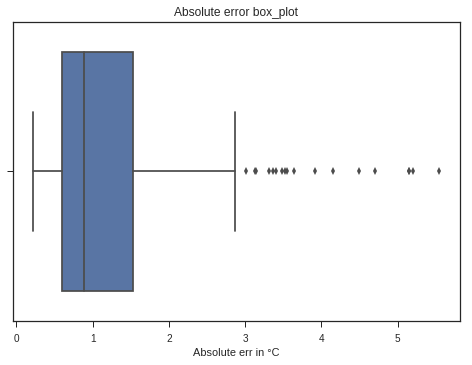

In [245]:
Y_predicted = model_cnn.predict(X_test_cnn)
rmse        = np.sqrt(metrics.mean_squared_error(y_test,Y_predicted))
abs_err     = np.mean(np.abs(y_test-Y_predicted),1)
mae         = np.mean(abs_err)

Y_predicted_train = model_cnn.predict(X_train_cnn)
rmse_train        = np.sqrt(metrics.mean_squared_error(y_train,Y_predicted_train))
abs_err_train     = np.mean(np.abs(y_train-Y_predicted_train),1)
mae_train         = np.mean(abs_err_train)

RMS_lab = sqrt(mean((Y_predicted - y_test)**2,1))
print("mae_train  = " + str(round(mae_train,3))+"C°")
print("rmse_train = " + str(round(rmse_train,3))+"C°")
print("mae_test   = " + str(round(mae,3))+"C°")
print("rmse_test  = " + str(round(rmse,3))+"C°")

RMS_lab_train = sqrt(mean((Y_predicted_train - y_train)**2,1))
print("RMS_train  = "+str(np.round(np.mean(RMS_lab_train),2))+"C°")
RMS_lab_test = sqrt(mean((Y_predicted - y_test)**2,1))
print("RMS_test   = "+str(np.round(np.mean(RMS_lab_test),2))+"C°")

sns.boxplot(abs_err)
plt.title('Absolute error box_plot')
plt.xlabel('Absolute err in °C')

## RESULTS BASELINE

Here we have assert manually in qualitative results, what we have evaluated in Model section.

The map of label is a qualitative way to compare our classification to the one of G Maze on vertical temperature
profiles.

The ratio of good assignment quantify the error of assignement of a given feature to it's correct latent mode.


We obtain the following table :

|            MODEL\SET                    | MAE_train | RMSE_train | MAE_Eval | RMSE_eval |
|--------------------------------|-----------|------------|----------|-----------|
| Linear Model     PCA = 0.999   | 1.96      | 2.75       | 2.09     | 2.96      |
| EM - K Means K=4,PCA = 0.999   | 1.54      | 2.39       | 1.86     | 2.88      |
| EM - K Means K=3,PCA = 0.999   | 1.65      | 2.51       | 1.96     | 2.99      |
| Linear Model     PCA = 0.99    | 2.12      | 2.93       | 2.23     | 3.15      |
| EM - K Means K=4,PCA = 0.99    | 2.05      | 3.31       | 2.26     | 3.52      |
| EM - K Means K=3,PCA = 0.99    | 1.93      | 2.85       | 2.03     | 3         |



Linear Model looks robust

##  BAYESIAN INFORMATION CRITERION
In statistics, the Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred. It is based on the likelihood function and on the number of parameters of the model involved.

When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. BIC  attempts to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC.

In our case, the Bayesian Information Criterion (BIC) is calculted given the following formula :

<img src="https://latex.codecogs.com/svg.latex?\Large&space;BIC=-2*log(lik)+n_{params}*log(size_{samples})" title="BIC" />



###  Computing the BIC
- 2-7 classes
- 30 iterations of randomized initialization EM
- 30 iterations for each EM algorithm

To effectively run the experiment toggle the boolean : Execute_experiment

In [0]:
def BIC_calculation_orth(inputs):
    [X_orth,Y_orth,K,method,iter_EM,clust] = inputs
    lambda_init,Beta_init,Sigma_init = lib.init_EM_latent_class_regression(X_orth,Y_orth,K,method,clust)
    log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat=lib.EM_latent_class_regression(X_orth,Y_orth,lambda_init,Beta_init,Sigma_init,iter_EM)
    sample_size = Y_orth.shape[0]*Y_orth.shape[1]
    nb_parameters =Sigma_init.shape[0]*Sigma_init.shape[1]*Sigma_init.shape[2] + Beta_hat.shape[0]*Beta_hat.shape[1]*Beta_hat.shape[2]
    BIC_ = -2*log_lik[-1] + nb_parameters*log(sample_size)
    return(BIC_,nb_parameters)


In [0]:
from multiprocessing import Pool
Execute_experiment = False

def imap_unordered_bar(func, args, n_processes = 2):
    """
    Function to have a tqdm style progress bar on parallel processes, works as pmap
    """
    p = Pool(n_processes)
    res_list = []
    with tqdm(total = len(args)) as pbar:
        for i, res in tqdm(enumerate(p.imap_unordered(func, args))):
            pbar.update()
            res_list.append(res)
    pbar.close()
    p.close()
    p.join()
    return res_list

if Execute_experiment:
    BIC={}
    nb_class=[2,3,4,5,6,7]
    len_class =len(nb_class)

    inputs=[]
    iter_EM=[40,30,30,30,30,30]
    method ="random"
    nb_iter_per_parameters = 10
    for i in range(len_class):
        for j in range(nb_iter_per_parameters):
            clust =np.array([np.random.randint(0,nb_class[i]) for l in range(size(Y_orth,0))])
            inputs.append([X_orth,Y_orth,nb_class[i],method,iter_EM[i],clust])
    BICs_ = imap_unordered_bar(BIC_calculation_orth, inputs)

You should have something like this, this experiment takes times. (ET : 6x30x30 EM algorithm ~ 90min)

With Variance_feature = 0.99 and Variance_target = 0.99


![](https://raw.githubusercontent.com/gcosne/OceanographyProject/master/figure/boxplotBIC_2_to_7_classes.png)

In [36]:
!mkdir /content/figure

mkdir: cannot create directory ‘/content/figure’: File exists


In [0]:
  import pickle
  from google.colab import files
  f = open('BICS99.pckl', 'wb')
  pickle.dump(BICs_, f)
  f.close()
  files.download('BICS99.pckl')


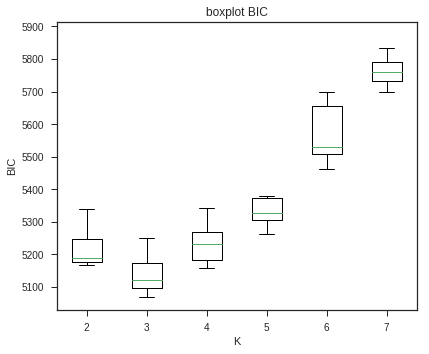

In [46]:
import pickle
from google.colab import files 
if Execute_experiment:
   
    pylab.rcParams['figure.figsize']=(8,6)
    l1 = len(nb_class)
    array_struct = zeros((l1,nb_iter_per_parameters))
    parameters_struct_ = zeros((l1,nb_iter_per_parameters))

    for i in range(l1):
        for p in range(nb_iter_per_parameters):
            array_struct[i,p]=BICs_[i*nb_iter_per_parameters+p][0]
            parameters_struct_[i,p]=BICs_[i*nb_iter_per_parameters+p][1]

    fig = plt.figure(figsize=(5,4))
    ax = fig.add_axes([1,1,1,1])
    plt.boxplot(array_struct.T,labels=[2,3,4,5,6,7])
    plt.title("boxplot BIC(K)")
    xlabel("K")
    ylabel("BIC")
    plt.savefig("/content/figure/boxplotBIC_2_to_7_classes_99.png",bbox_inches='tight')   

    f = open('array_struct_99.pckl', 'wb')
    pickle.dump([array_struct], f)
    f.close()
    files.download('array_struct_99.pckl')
    files.download('/content/figure/boxplotBIC_2_to_7_classes_99.png')

### Generate several EM algorithms

- Generate many EM and store pi_hats (probability of belonging to a class)
- Re-label to minimize a given distance
- The maximum occuring label is chosen as the most likely class

In [18]:
## Compute the nb_iter_per_parameters initialisation of EM algorithm for a nb of class given
Execute_experiment = True
nb_iter_per_parameters = 150
nb_class = 4
if Execute_experiment :
    inputs   = []
    iter_EM  = 50
    method   ="random"
    for j in range(nb_iter_per_parameters):
        clust=np.array([np.random.randint(0,nb_class) for i in range(size(Y_orth,0))])
        inputs.append([X_orth,Y_orth,nb_class,method,iter_EM,clust])
        
    # Parallelize the execution of the EM algorithm (random init)
    pi_hats_ = imap_unordered_bar(lib.EM_with_init, inputs)

100%|██████████| 150/150 [1:46:29<00:00, 35.98s/it]
150it [1:46:29, 35.98s/it]



In [19]:
import pickle
from google.colab import files 

# Save parameters 
save_res = True
print("save_res=",save_res)
if save_res :
    f = open('pi_hats_train_99.pckl', 'wb')
    pickle.dump([pi_hats_], f)
    f.close()
    files.download('pi_hats_train_99.pckl')
    
else:
  # Get the patches :
  gdd.download_file_from_google_drive(file_id='1oTtAE3Nf2YSz24R9MQ9oIQ2cATZmsjg7',
                                     dest_path='/content/pi_hats_train.pckl',
                                     unzip=False) 
  f = open('/content/pi_hats_train.pckl', 'rb')
  [pi_hats_] = pickle.load(f)
  f.close()

save_res= True


**Hard encoding results keeping the maximum likelihood**

In [0]:
def geo_error(lat_lng,index_ref,new_index,nb_class):
    """
    Define the geographical error of assignment using chamfer distance.
    """
    return(array([[chamfer_distance(lat_lng[np.where(index_ref==i),:].squeeze(),lat_lng[np.where(new_index==j),:].squeeze()) for i in range(nb_class)] for j in range(nb_class)]))

def chamfer_distance(X,Y):
    """
    Distance used in pattern recognition : looks for similar shape between the clouds.
    """
    sum_x = 0
    for i in range(len(X)):
        sum_x += min([np.linalg.norm(X[i]-Y[k]) for k in range(len(Y))])
    sum_y = 0
    for i in range(len(Y)):
        sum_x += min([np.linalg.norm(Y[i]-X[k]) for k in range(len(X))])
    return(sum_x+sum_y)

lat_lng = zeros((len(lat),2))
lat_lng[:,0]=lat
lat_lng[:,1]=lon

# We take G.Maze labels as "ground_truth": gt_label
gt_label = ndarray.astype(label.squeeze()-1,int)
color=["#FF0000","#FFF000","#00FFFF","#00FF00"]

**We observe how the best simulation is qualitatively performing**

It should look like this :

![](https://github.com/gcosne/OceanographyProject/blob/master/figure/label_best_pred.png?raw=true)

confusion_matrice = 
[[0.16666667 0.03703704 0.68518519 0.11111111]
 [0.         0.50574713 0.47126437 0.02298851]
 [0.3        0.4125     0.225      0.0625    ]
 [0.22222222 0.01984127 0.17063492 0.58730159]]
accuracy= 0.4630021141649049
color=Red yellow, turquoise green


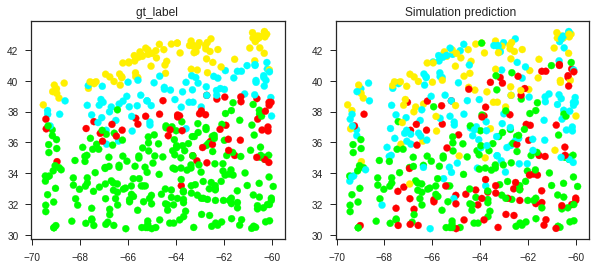

In [21]:
Execute_experiment=True
if Execute_experiment :
    likelihood_ = np.array([pi_hats_[k][1][-1] for k in range(nb_iter_per_parameters)])
    best_candidate= np.argmax(likelihood_)
    pi_hat_best = pi_hats_[best_candidate][0]

    hard_best = ndarray.astype(np.argmax(pi_hat_best,1),int)
    gt_label = ndarray.astype(label.squeeze()-1,int)[ind_train]

    geo_distance = geo_error(lat_lng[ind_train,:],gt_label,hard_best,nb_class)
    assignment_matrix  = la.linear_assignment(geo_distance) # distance_matrix)

    hard_best_ = zeros(len(hard_best))
    for k in range(nb_class):
        hard_best_[np.where(hard_best==k)]= assignment_matrix[k][1]
    hard_best_=ndarray.astype(hard_best_,int)
    from sklearn.metrics import confusion_matrix
    y_true = gt_label
    y_pred = hard_best_
    conf_mat = confusion_matrix(y_true, y_pred)

    norm_confusion_mat = array([conf_mat[k] / sum(conf_mat[k]) for k in range(len(conf_mat))])
    print("confusion_matrice = ")
    print(norm_confusion_mat)

    accurate_assignment= len(find([y_true[k]==y_pred[k] for k in range(len(y_true))]))
    accuracy = accurate_assignment/len(y_true)
    print("accuracy=",accuracy)
    print("color=Red yellow, turquoise green")
    
    real_color = [color[gt_label[k]] for k in range(len(hard_best))]
    color_stat = [color[hard_best_[k]] for k in range(len(hard_best))]
    figure,ax = subplots(figsize=(10,4))
    subplot(121)
    scatter(lon[ind_train],lat[ind_train],color=real_color)
    title("gt_label ")
    subplot(122)
    scatter(lon[ind_train],lat[ind_train],color=color_stat)
    title("Simulation prediction ")

## COMBINATION OF THE EM ALGORITHM

Now we are going to combine all the simulations :

In [33]:
## Combine the outputs
Execute_experiment=True
if Execute_experiment :
    # index_class is the first simulation output, we choose one class per sample (most likely)
    index_class = gt_label
    
    for k in range(nb_class):
        ind_class_k = np.where(index_class==k)
        weight= pi_hats_[0][0][ind_class_k,k].squeeze()
        vector_temp =Y_orth[ind_class_k,:].squeeze()
        
    # big_matrix is the matrix in which we store re-labeled classes
    big_matrix = zeros((len(index_class),len(pi_hats_)))   
        
    for j in tqdm(range(0,len(pi_hats_))):
        new_index_class = np.argmax(pi_hats_[j][0],1)
        
        for k in range(nb_class):
            weight= pi_hats_[j][0][new_index_class,k].squeeze()
            vector_temp =Y_orth[new_index_class,:].squeeze()
        ground_truth_label = index_class
        estimated_label    = new_index_class
        
        geo_distance = geo_error(lat_lng,index_class,new_index_class,nb_class)
        assignment_matrix  = la.linear_assignment(geo_distance)#

        new_index_class_ = zeros(len(new_index_class))
        for k in range(nb_class):
            new_index_class_[np.where(new_index_class==k)]= assignment_matrix[k][1]
        big_matrix[:,j] = new_index_class_

    big_matrix=ndarray.astype(big_matrix,int)
    
    # We take the most likely class according to the simulations
    statistical_class = [np.bincount(big_matrix[k,:]).argmax() for k in range(big_matrix.shape[0])]


100%|██████████| 150/150 [06:12<00:00,  2.46s/it]


### How well is the assignment of one cloud 

**Run several time this cell to see one EM algorithm output**

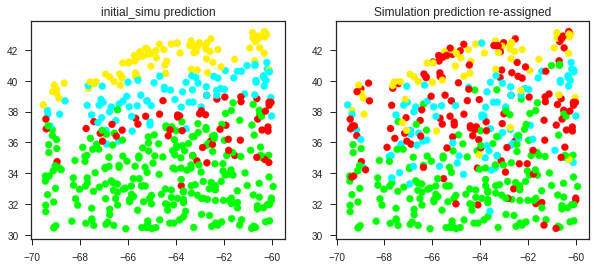

In [46]:
Execute_experiment=True
if Execute_experiment :
    simu +=1
    real_color = [color[gt_label[k]] for k in range(len(statistical_class))]
    color_stat = [color[big_matrix[k,simu]] for k in range(len(statistical_class))]
    figure,ax = subplots(figsize=(10,4))
    subplot(121)
    scatter(lon[ind_train],lat[ind_train],color=real_color)
    title("initial_simu prediction")
    subplot(122)
    scatter(lon[ind_train],lat[ind_train],color=color_stat)
    title("Simulation prediction re-assigned")

**We have combined the differents simulation, now we assign the label with those of the ground_truth so we can compare**
Results should look like this : 

![](https://raw.githubusercontent.com/gcosne/OceanographyProject/master/figure/4classes_assignment.png)

In [0]:
save_res = False
Execute_experiment= True
if Execute_experiment :
    color=["#FF0000","#FFF000","#00FFFF","#00FF00"]
    color_stat = [color[statistical_class[k]] for k in range(len(statistical_class))]
    gt_label   = ndarray.astype(label-1,int).squeeze()[ind_train]
    real_color =  [color[gt_label[k]] for k in range(len(gt_label))]
    
    # Assignment between stat and ground truth
    ground_truth_rpz_class= zeros((nb_class,Y_orth.shape[1]))
    rpz_stat_class = zeros((nb_class,Y_orth.shape[1])) 

    for k in range(nb_class):
        ground_truth_rpz_class[k,:] = np.mean(Y_orth[np.where(gt_label==k),:].squeeze(),0)
        rpz_stat_class[k,:] = np.mean(Y_orth[np.where(np.array(statistical_class)==k),:].squeeze(),0)

    distance_matrix    = array([[np.linalg.norm(ground_truth_rpz_class[i,:]-rpz_stat_class[j,:]) for i in range(nb_class)] for j in range(nb_class)])                      
    assignment_matrix = la.linear_assignment(distance_matrix)
    print(assignment_matrix)
    new_stat_class = zeros(len(statistical_class))
    for k in range(nb_class):
        new_stat_class[np.where(np.array(statistical_class)==k)]= assignment_matrix[k][1]
        
    new_stat_class=ndarray.astype(new_stat_class,int)
    color_stat = [color[new_stat_class[k]] for k in range(len(statistical_class))]
    figure,ax = subplots(figsize=(10,4))
    subplot(121)
    scatter(lon[ind_train],lat[ind_train],color=real_color)
    title("Ground Truth")
    subplot(122)
    scatter(lon[ind_train],lat[ind_train],color=color_stat)
    title("Combined Simulations Prediction")
    if save_res:
        savefig("/content/figure/4classes_assignment.png")

**Here we print some metrics : confusion matrix, accuracy**

PCA = 0.99 

|      Confusion| Matrix|accuracy |= 0.71
|-------|------|-------|--------|
| 0.14 | 0    | 0.79 | 0.07 |
| 0     | 0.49 | 0.51  | 0      |
| 0     | 0.41 | 0.59  | 0      |
| 0.04  | 0    | 0.01  | 0.95   |


PCA = 0.999 


| Confusion | Matrix | accuracy | =0.84 |
|-----------|--------|----------|-------|
| 0.65      | 0.02   | 0.15     | 0.18  |
| 0.04      | 0.86   | 0.09     | 0.01  |
| 0.07      | 0.18   | 0.69     | 0.06  |
| 0.06      | 0.01   | 0.01     | 0.92  |




In [48]:
print("Execute_experiment=",Execute_experiment)
Execute_experiment =True
if Execute_experiment:
    from sklearn.metrics import confusion_matrix
    y_true = gt_label
    y_pred = new_stat_class
    conf_mat = confusion_matrix(y_true, y_pred)

    norm_confusion_mat = array([conf_mat[k] / sum(conf_mat[k]) for k in range(len(conf_mat))])
    print("confusion_matrix = ")
    print(norm_confusion_mat)

    accurate_assignment= len(find([y_true[k]==y_pred[k] for k in range(len(y_true))]))
    accuracy = accurate_assignment/len(y_true)
    print("accuracy=",accuracy)
    print("color=Red yellow, turquoise green")


Execute_experiment= True
confusion_matrix = 
[[0.62962963 0.05555556 0.14814815 0.16666667]
 [0.24137931 0.73563218 0.         0.02298851]
 [0.1125     0.2        0.6125     0.075     ]
 [0.21825397 0.00396825 0.12301587 0.6547619 ]]
accuracy= 0.6596194503171248
color=Red yellow, turquoise green


In [49]:
save_res = False
print("save_res=",save_res)
if save_res :
    f = open('y_pred.pckl', 'wb')
    pickle.dump([y_pred], f)
    f.close()
    files.download('figure/4classes_assignment.png') 
    files.download('y_pred.pckl') 

save_res= False


In [0]:
# We redefine init_EM function to initialize its EM with labels pre determined combining several runs
def init_EM_latent_class_regression(X,Y,K,method,clust1=[0]):   
    # size
    n=size(Y,0)
    nb_features = X.shape[1]
    depth = Y.shape[1]
    
    # clustering method
    if method == "kmeans":
        clust = KMeans(n_clusters=K, random_state=0).fit_predict(hstack((X[:,1:X.shape[1]],Y))) # see why its better than hstack((X[:,1:X.shape[1]],Y))
        #hstack((array([X[:,1]]).T,Y))
    elif method == "random":
        if len(clust1)>1:
            clust=clust1
        else:
            clust=np.array([np.random.randint(0,K) for i in range(n)]);
    elif method=="init_weight":
        clust=clust1
    # initialize lambda
    hist_k = plt.hist(clust,K,density=True);
    plt.close()
    width_bins = hist_k[1][1] -hist_k[1][0] 
    nb_k = hist_k[0]*width_bins * len(X)

    lambda_init=zeros(K)
    for k in range(K):
        lambda_init[k]=nb_k[k]/n

    Beta_init  =array(zeros((K,nb_features,depth)))
    Sigma_init =array(zeros((K,depth,depth)))

    # initialize Beta and Sigma
    for k in range(0,K): 
        Beta_init[k,:,:] = np.linalg.lstsq(X[np.where(clust==k)[0],:],Y[np.where(clust==k)[0],:])[0]
        Sigma_init[k,:,:] = cov((Y[np.where(clust==k)[0],:]-X[np.where(clust==k)[0],:]@(Beta_init[k,:,:].reshape((nb_features,depth)))).T)

    return(lambda_init,Beta_init,Sigma_init)

### Init EM with combination of output

Beta and Sigma are saved after this run to make prediction in the future.

[[0 2]
 [1 1]
 [2 0]
 [3 3]]


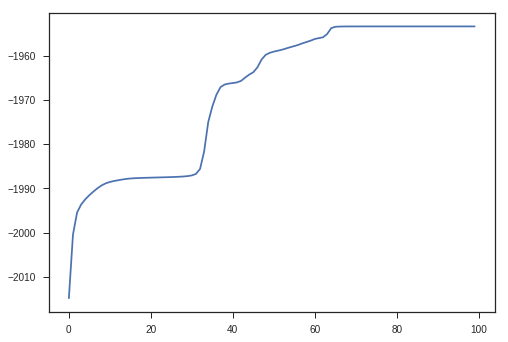

In [51]:
# Generate the pseudo repartition as an init
save_res=True
Execute_experiment=True
if Execute_experiment :
    K = 4
    iter_EM=100
    method ="init_weight"
    lambda_init,Beta_init,Sigma_init = init_EM_latent_class_regression(X_orth,Y_orth,K,method,y_pred)
    log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat=lib.EM_latent_class_regression(X_orth,Y_orth,lambda_init,Beta_init,Sigma_init,iter_EM)
    kmeans_index_class =ndarray.astype(np.argmax(pi_hat,1),int)
    rpz_kmeans_class = zeros((nb_class,Y_orth.shape[1]))
    ground_truth_rpz_class= zeros((nb_class,Y_orth.shape[1]))
    for k in range(nb_class):
        ground_truth_rpz_class[k,:] = np.mean(Y_orth[np.where(gt_label==k),:].squeeze(),0)
        rpz_kmeans_class[k,:] = np.mean(Y_orth[np.where(np.array(kmeans_index_class)==k),:].squeeze(),0)

    # Assignment between kmeans and ground truth
    distance_matrix    = array([[np.linalg.norm(ground_truth_rpz_class[i,:]-rpz_kmeans_class[j,:]) for i in range(nb_class)] for j in range(nb_class)])                      
    assignment_matrix = la.linear_assignment(distance_matrix)
    new_kmeans_class = zeros(len(kmeans_index_class))
    for k in range(nb_class):
        new_kmeans_class[np.where(np.array(kmeans_index_class)==k)]= assignment_matrix[k][1]

    new_kmeans_class = ndarray.astype(new_kmeans_class,int)
    color_kmeans = [color[new_kmeans_class[k]] for k in range(len(new_kmeans_class))]
    plot(log_lik)
    print(assignment_matrix)  


In [0]:
figure,ax = subplots(figsize=(10,5))
subplot(121)
scatter(lon[ind_train],lat[ind_train],color=real_color)
title("Ground Truth")
subplot(122)
scatter(lon[ind_train],lat[ind_train],color=color_kmeans)
title("init Prediction")
if save_res:
    savefig("figure/4classes_assignment_init_pred.png")

Results should look like this with a variance to kept : PCA = 0.99

| Confusion| Matrix|accuracy |= 0.69
|------|------|------|------|
| 0.14 | 0.01 | 0.79 | 0.05 |
| 0    | 0.49 | 0.51 | 0    |
| 0    | 0.45 | 0.55 | 0    |
| 0.05 | 0    | 0.02 | 0.93 |


Or PCA = 0.999

| Confusion | Matrix | accuracy | =0.80 |
|-----------|--------|----------|-------|
| 0.76      | 0.02   | 0.13     | 0.09  |
| 0.01      | 0.84   | 0.14     | 0.01  |
| 0.1       | 0.11   | 0.76     | 0.03  |
| 0.15      | 0.01   | 0.03     | 0.81  |

In [54]:
# Compare results : 
print("Execute_experiment=",Execute_experiment)
if Execute_experiment :
    from sklearn.metrics import confusion_matrix
    y_true = gt_label
    y_pred = new_kmeans_class
    conf_mat = confusion_matrix(y_true, y_pred)

    norm_confusion_mat = array([conf_mat[k] / sum(conf_mat[k]) for k in range(len(conf_mat))])
    print("confusion_matrice = ")
    print(norm_confusion_mat)

    accurate_assignment= len(find([y_true[k]==y_pred[k] for k in range(len(y_true))]))
    accuracy = accurate_assignment/len(y_true)
    print("accuracy=",accuracy)
    print("color=Red yellow, turquoise green")
else:
  gdd.download_file_from_google_drive(file_id='1VtTzJ7UOAp-n-DkboaGdksI6RMHxquU1',dest_path='/content/y_pred.pckl',unzip=False)
  f = open('/content/y_pred.pckl', 'rb')
  [y_pred] = pickle.load(f)

Execute_experiment= True
confusion_matrice = 
[[0.14814815 0.09259259 0.62962963 0.12962963]
 [0.01149425 0.49425287 0.48275862 0.01149425]
 [0.6125     0.2        0.175      0.0125    ]
 [0.1468254  0.02777778 0.24206349 0.58333333]]
accuracy= 0.44820295983086683
color=Red yellow, turquoise green


In [0]:
# Save parameters 
save_res = False
print("save_res=",save_res)
if save_res :
    f = open('store999_train.pckl', 'wb')
    pickle.dump([log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat], f)
    f.close()
    files.download('store999_train.pckl')

save_res= True


## MODEL COMBINED EM MODEL 

#### Create Model

In [0]:
class EM_COMBIINED_MODEL:
  def __init__(self):
    self.var_feature = None
    self.var_target  = None
    self.X_train     = None 
    self.y_train     = None
    self.K           = None
    self.iter_EM     = None
    self.clust       = None
    self.store       = None

  def temperature_profile(self,X_orth,Beta_hat,label):
    """
    return the targeted temperature profile using features and linear coefficients 
    with : X_orth surface observation
           Beta_hat : Regression coefficient
           label:  label of the sample observed
    """
    output = np.array([X_orth[l,:]@Beta_hat[label[l],:,:] for l in range(len(label))])
    return(output)
  
  def fit(self):
    var_feature = self.var_feature
    var_target  = self.var_target 
    X_train     = self.X_train  
    y_train     = self.y_train
    K           = self.K
    iter_EM     = self.iter_EM
    clust       = self.clust
    store       = self.store

    # Transformation – Standard Scaling of the features & target
    sc_features = StandardScaler()
    sc_target   = StandardScaler()

    X_scaled  = sc_features.fit_transform(X_train)
    Y_scaled  = sc_target.fit_transform(y_train)

    acp_features = PCA(svd_solver='full',n_components =self.var_feature)
    acp_target   = PCA(svd_solver='full',n_components =self.var_target)

    X_orth = acp_features.fit_transform(X_scaled)
    Y_orth = acp_target.fit_transform(Y_scaled)
    method = "init_weight"
    
    if not (clust is None):
      lambda_init,Beta_init,Sigma_init = init_EM_latent_class_regression(X_orth,Y_orth,K,method,clust1=clust)
      log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat = lib.EM_latent_class_regression(X_orth,Y_orth,lambda_init,Beta_init,Sigma_init,iter_EM)
    else:
      [log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat] = store
      
    fig, axes = plt.subplots(1,2)
    axes[0].plot(log_lik)
    axes[0].set_title('Log_lik curve to assert convergence')
    axes[0].set_xlabel('Iteration EM algorithm')
    axes[0].set_ylabel('Log Likelihood')
    # From pi_hat we hardcode the label 
    label_pred = ndarray.astype(np.argmax(pi_hat,1),int)
    probability_density = zeros((len(X_orth),K))
    multivariate_normal_law=[]
    for label in range(K):   
        ind_label = find(label_pred==label)
        mean_ = mean(X_orth[ind_label,:],0)
        cov_  = cov(X_orth[ind_label,:].T)
        axes[1].plot(mean_)
        for k in range(len(X_orth)):
            probability_density[k,label]= multivariate_normal.pdf(X_orth[k,:], mean=mean_, cov=cov_)
        multivariate_normal_law.append(multivariate_normal(mean=mean_, cov=cov_))
    
    axes[1].set_title('Visualization of Gaussian mean')
    axes[1].set_xlabel('n th component of PCA')
    return([K,acp_features,acp_target,sc_features,sc_target,multivariate_normal_law,Beta_hat])

  def predict(self,ret_fit, X_test):
    K               = ret_fit[0]
    acp_features    = ret_fit[1]
    acp_target      = ret_fit[2]
    sc_features     = ret_fit[3]
    sc_target       = ret_fit[4]
    multivariate_normal_law = ret_fit[5]
    Beta_hat        = ret_fit[6]
    
    X_scaled_test  = sc_features.transform(X_test)
    #     print('X_test.shape',X_test.shape)
    X_orth_test = acp_features.transform(X_scaled_test)
    #     print('X_test.shape',X_test.shape)
    probability_density_test = zeros((len(X_orth_test),K))
    for label in range(K):   
        for k in range(len(X_orth_test)):
            probability_density_test[k,label]= multivariate_normal_law[label].pdf(X_orth_test[k,:])
    label_attributed_test = np.argmax(probability_density_test,1)
    
    temp_pred_lab_test = self.temperature_profile(X_orth_test,Beta_hat,label_attributed_test)

    # ACP inverse
    temp_true_profile = acp_target.inverse_transform(temp_pred_lab_test) 

    # Rescaling
    rescale_temp =sc_target.inverse_transform(temp_true_profile) 
    return rescale_temp,label_attributed_test


#### Load Model

In [218]:
gdd.download_file_from_google_drive(file_id='1edS7qVOhvTPSMEED1ygiR5CjHo2Np1k9',dest_path = '/content/store999.pckl',unzip='False')

Unzipping...

In [234]:
gdd.download_file_from_google_drive(file_id='1iJzQZYZIvDCIIVSNXXxCBXFr_gTmox_H',dest_path = '/content/store99.pckl',unzip='False')
# Here we load the stored data
import pickle

f = open('/content/store99.pckl', 'rb')
store1 = pickle.load(f)
f.close()

Unzipping...

In [0]:
# Here we load the stored data
import pickle

f = open('/content/store999.pckl', 'rb')
store = pickle.load(f)
f.close()

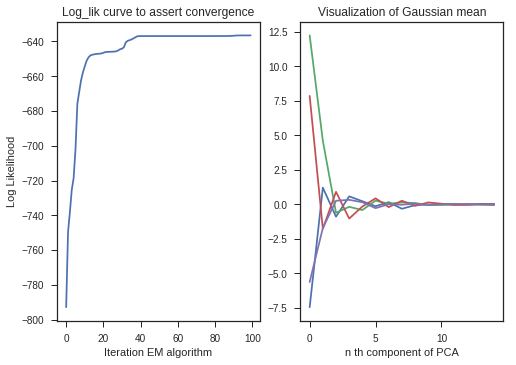

In [220]:
em_model = EM_COMBIINED_MODEL()

em_model.var_feature  = var_feature
em_model.var_target   = var_target
em_model.X_train      = X_train 
em_model.y_train      = y_train
em_model.K            = 4
em_model.iter_EM      = 100
# em_model.clust        = clust
em_model.store        = store
paramModel_em_model = em_model.fit()

**INIT A MODEL WITH G.MAZE LABEL**

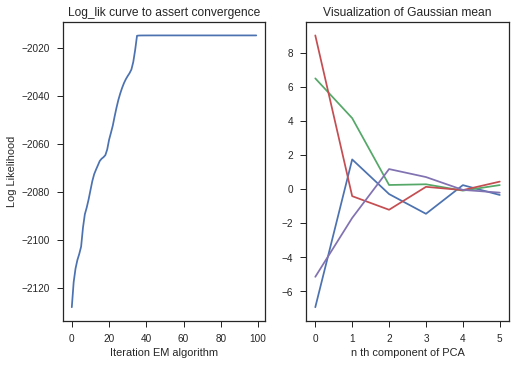

In [228]:
em_model_gt = EM_COMBIINED_MODEL()

em_model_gt.var_feature  = 0.99
em_model_gt.var_target   = 0.99
em_model_gt.X_train      = X_train 
em_model_gt.y_train      = y_train
em_model_gt.K            = 4
em_model_gt.iter_EM      = 100
em_model_gt.clust        = gt_label
# em_model_gt.store        = store
paramModel_em_model_gt = em_model_gt.fit()

**INIT A MODEL WITH 0.99 PCA COMBINED**

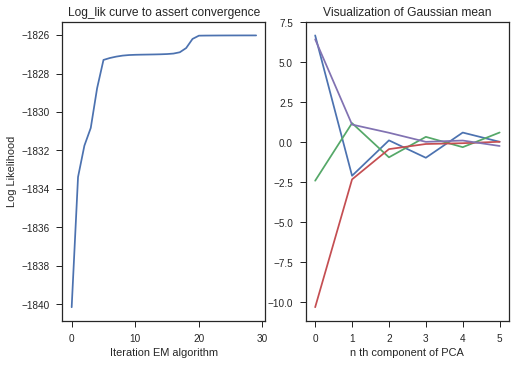

In [237]:
em_model_099 = EM_COMBIINED_MODEL()

em_model_099.var_feature  = 0.99
em_model_099.var_target   = 0.99
em_model_099.X_train      = X
em_model_099.y_train      = Y
em_model_099.K            = 4
em_model_099.iter_EM      = 100
# em_model_099.clust        = gt_label
em_model_099.store        = store1
paramModel_em_model_099 = em_model_099.fit()

### Evaluate Model



mae_train  = 1.495C°
rmse_train = 2.332C°
mae_test   = 1.899C°
rmse_test  = 2.949C°
RMS_train  = 1.78C°
RMS_test   = 2.25C°


Text(0.5, 0, 'Absolute err in °C')

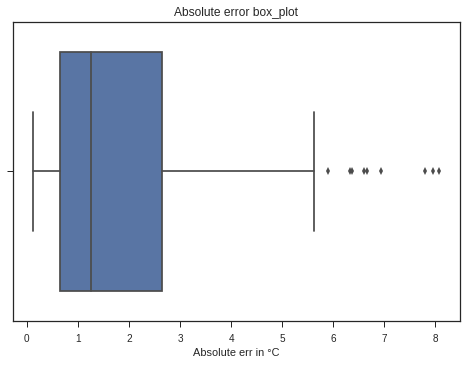

In [223]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error

Y_predicted,label_attributed_test = em_model.predict(paramModel_em_model,X_test)
rmse        = np.sqrt(metrics.mean_squared_error(y_test,Y_predicted))
abs_err     = np.mean(np.abs(y_test-Y_predicted),1)
mae         = np.mean(abs_err)

Y_predicted_train,label_attributed_train = em_model.predict(paramModel_em_model,X_train)
rmse_train        = np.sqrt(metrics.mean_squared_error(y_train,Y_predicted_train))
abs_err_train     = np.mean(np.abs(y_train-Y_predicted_train),1)
mae_train         = np.mean(abs_err_train)

RMS_lab = sqrt(mean((Y_predicted - y_test)**2,1))
print("mae_train  = " + str(round(mae_train,3))+"C°")
print("rmse_train = " + str(round(rmse_train,3))+"C°")
print("mae_test   = " + str(round(mae,3))+"C°")
print("rmse_test  = " + str(round(rmse,3))+"C°")

RMS_lab_train = sqrt(mean((Y_predicted_train - y_train)**2,1))
print("RMS_train  = "+str(np.round(np.mean(RMS_lab_train),2))+"C°")
RMS_lab_test = sqrt(mean((Y_predicted - y_test)**2,1))
print("RMS_test   = "+str(np.round(np.mean(RMS_lab_test),2))+"C°")

sns.boxplot(abs_err)
plt.title('Absolute error box_plot')
plt.xlabel('Absolute err in °C')

### Evaluate Model II



mae_train  = 1.754C°
rmse_train = 2.775C°
mae_test   = 1.904C°
rmse_test  = 2.982C°
RMS_train  = 2.06C°
RMS_test   = 2.24C°


Text(0.5, 0, 'Absolute err in °C')

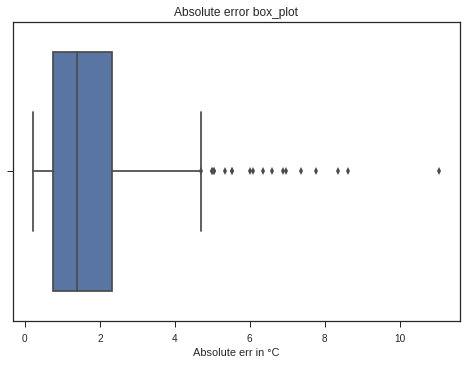

In [229]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error

Y_predicted,label_attributed_test = em_model_gt.predict(paramModel_em_model_gt,X_test)
rmse        = np.sqrt(metrics.mean_squared_error(y_test,Y_predicted))
abs_err     = np.mean(np.abs(y_test-Y_predicted),1)
mae         = np.mean(abs_err)

Y_predicted_train,label_attributed_train = em_model_gt.predict(paramModel_em_model_gt,X_train)
rmse_train        = np.sqrt(metrics.mean_squared_error(y_train,Y_predicted_train))
abs_err_train     = np.mean(np.abs(y_train-Y_predicted_train),1)
mae_train         = np.mean(abs_err_train)

RMS_lab = sqrt(mean((Y_predicted - y_test)**2,1))
print("mae_train  = " + str(round(mae_train,3))+"C°")
print("rmse_train = " + str(round(rmse_train,3))+"C°")
print("mae_test   = " + str(round(mae,3))+"C°")
print("rmse_test  = " + str(round(rmse,3))+"C°")

RMS_lab_train = sqrt(mean((Y_predicted_train - y_train)**2,1))
print("RMS_train  = "+str(np.round(np.mean(RMS_lab_train),2))+"C°")
RMS_lab_test = sqrt(mean((Y_predicted - y_test)**2,1))
print("RMS_test   = "+str(np.round(np.mean(RMS_lab_test),2))+"C°")

sns.boxplot(abs_err)
plt.title('Absolute error box_plot')
plt.xlabel('Absolute err in °C')

# TESTING ON A BIGGER DATASET OVER A YEAR PERIOD

We are using Cartopy Here : 

A tutorial can be found at :
https://ipython-books.github.io/146-manipulating-geospatial-data-with-cartopy/

To install it one may run : !conda install -c conda-forge cartopy --yes


As our patches are not on a regular grid we choose to visualize the errors : 
- With a simple scatter


## Install Cartopy

In [0]:
!apt-get -qq install python-cartopy python3-cartopy
import cartopy

In [0]:
# Import everything to run cartopy 
import io
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as col
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader
import os
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
from cartopy import config
import cartopy.crs as ccrs

# Load the patches 
fname = os.path.join('ALLPATCHES_NX13_NY13.nc')
dataset = netcdf_dataset(fname)
sst = dataset.variables['SST'][:,6,6]
lats = dataset.variables['lat'][:,6,6]
lons = dataset.variables['lon'][:,6,6]


## Visualize Some results

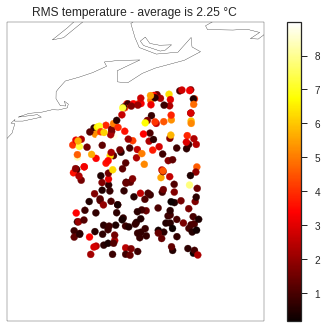

In [0]:
ax = plt.axes(projection=ccrs.PlateCarree())
CS3 =ax.scatter(lons[ind_test],lats[ind_test],c=RMS_lab,transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()
title("RMS temperature - average is "+str(round(np.mean(RMS_lab),2)) + " °C ")
plt.colorbar(CS3)
plt.show()

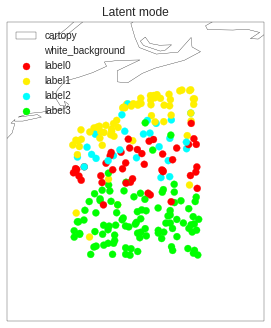

In [0]:
color=["#FF0000","#FFF000","#00FFFF","#00FF00"]
color_label = [color[label_attributed_test[k]] for k in range(len(ind_test))]

ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(0,0,c=color[0])
ax.scatter(0,0,c=color[1])
ax.scatter(0,0,c=color[2])
ax.scatter(0,0,c=color[3])
ax.legend(['cartopy','white_background','label0','label1','label2','label3'])
CS3 =ax.scatter(lons[ind_test],lats[ind_test],c=color_label,transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()

title("Latent mode")
plt.show()

## EVALUATE THE MODEL ON THE FULL 3D FIELD


In [0]:
def extract_patch(SLA,SST,ilat,ilon,itim):
    """Collect a patch of horizontal surface data
    """
    patch_length_lon = 6 # Half zonal length of the patch
    patch_length_lat = 6 # Half meridional length of the patch
    nx, ny = SLA['x'].size, SLA['y'].size    
    iy = range(ilat-patch_length_lat,ilat+patch_length_lat+1)
    ix = range(ilon-patch_length_lon,ilon+patch_length_lon+1)
    #     print(nx,ny)
    #     print(ix,"\n",iy)
    if ((ix[0]<0) | (ix[-1]>nx-1) | (iy[0]<0) | (iy[-1]>ny-1)):            
        print('ix:', ix)
        print('iy:', iy)
        print("Sample too close to boundaries")
        return False
    else: # Collecting:
        sla = SLA.isel(x=ix).isel(y=iy).isel(time_counter=itim).stack(patch=('y', 'x'))
        sst = SST.isel(x=ix).isel(y=iy).isel(time_counter=itim).stack(patch=('y', 'x'))
        dsout = xr.Dataset()
        dsout['SST'] = sst
        dsout['SLA'] = sla
        dsout = dsout.unstack('patch')
        return dsout
    
def replace_nan(X):
    X_new= X.flatten()
    is_nan = np.where(isnan(X_new))[0]
    mask = np.isnan(X_new)
    X_new[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), X_new[~mask])
    X_filled =X_new.reshape(X.shape)
    return(X_filled)

###Load data

In [0]:
!wget https://storage.googleapis.com/sonific01/NATL12/GSbox-NATL12-BAMT20_0306_gridT_NA.nc

--2019-03-09 12:54:15--  https://storage.googleapis.com/sonific01/NATL12/GSbox-NATL12-BAMT20_0306_gridT_NA.nc
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127532255 (2.9G) [application/x-netcdf]
Saving to: ‘GSbox-NATL12-BAMT20_0306_gridT_NA.nc’

GSbox-NATL12-BAMT20 100%[===================>]   2.91G  63.4MB/s    in 53s     

2019-03-09 12:55:08 (56.0 MB/s) - ‘GSbox-NATL12-BAMT20_0306_gridT_NA.nc’ saved [3127532255/3127532255]



In [0]:
filename = 'GSbox-NATL12-BAMT20_0306_gridT_NA.nc'

**Open the netcdf file**

In [0]:
ds = xr.open_dataset(filename)
SLA = ds['sossheig'].rename('SSH')
SST = ds['votemper'].sel(deptht=0,method='nearest').rename('SST')

Get the Temperature field in depth for time_counter =1

In [0]:
# Set the timestep
itim = 1

In [0]:
temp_depth = ds['votemper'].isel(time_counter=itim).values

In [0]:
temp_depth = replace_nan(temp_depth)
temp_depth = np.swapaxes(temp_depth, 1,2)
temp_depth.shape

(36, 127, 254)

Number of latitude, Number of longitude

In [0]:
nx, ny = SLA['x'].size, SLA['y'].size 

Get number of time_step

In [0]:
len_time= ds['time_counter'].shape[0]
patch_length_lon = 6 # Half zonal length of the patch
patch_length_lat = 6 # Half meridional length of the patch

In [0]:
# Training set lats/lons
# these values are used to set the frame of the map to plot
lats = lats.squeeze()
lons = lons.squeeze()

### Discovering the dataset with 1 timestep

** Size of the structure we would like to manipulate **

The total size of the structure is too large to manipulate, we have to work time step per time step

In [0]:
# Array to store the SST/SLA patches
patches_time = np.zeros((338,nx-patch_length_lon,ny-patch_length_lat))

# Array to store the Lat/Lng patches
lat_lng_patch =np.zeros((2,nx-patch_length_lon,ny-patch_length_lat))

In [0]:
Execute_experiment=False
if Execute_experiment:
    for l in tqdm(range(patch_length_lon,nx-patch_length_lon-1)):
        for j in range(patch_length_lat,ny-patch_length_lat-1):
            ilat, ilon = j, l
            # print(ilat,ilon,itim)
            patch = extract_patch(SLA,SST,ilat,ilon,itim)
            SST_ = patch['SST'].values.flatten()
            SLA_ = patch['SLA'].values.flatten()
            lat_lng_patch[0,l,j] = patch['nav_lat'][6,6].values
            lat_lng_patch[1,l,j] =patch['nav_lon'][6,6].values

            # Merge:
            features = np.concatenate((SLA_, SST_))
            patches_time[:,l,j] = features

Store the data : pickle

In [0]:
gdd.download_file_from_google_drive(file_id ='19_atN2bWp5AHDSxP-EEcHT1thtcmcfI6',dest_path = '/content/store_patches1.pckl',unzip=False)

In [0]:
import pickle
save_res = False
if save_res :
    f = open('store_patches'+str(itim)+'.pckl', 'wb')
    pickle.dump([patches_time,lat_lng_patch], f)
    f.close()
else:
    f = open('store_patches1'+'.pckl', 'rb')
    [patches_time,lat_lng_patch] = pickle.load(f)
    f.close()


In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#!cp /content/store_patches1.pckl /content/gdrive/My\ Drive/OceanographyProject/store_patches1.pckl

**Remove the first zeros : on the side of the map we can't generate patches**

In [0]:
patches_times = patches_time[:,patch_length_lon:nx-patch_length_lon-1,patch_length_lat:ny-patch_length_lat-1]
lat_lng_patch = lat_lng_patch[:,patch_length_lon:nx-patch_length_lon-1,patch_length_lat:ny-patch_length_lat-1]

### Predict temperature

Flat the features and lat_lng

In [0]:
flat_patches = patches_times.reshape((338,(nx-2*patch_length_lon-1)*(ny-2*patch_length_lat-1)))
lat_lng_patch_flat = lat_lng_patch.reshape(2,((nx-2*patch_length_lon-1)*(ny-2*patch_length_lat-1))).T

temp_depth = temp_depth[:,patch_length_lon:nx-patch_length_lon-1,patch_length_lat:ny-patch_length_lat-1]
temp_depth = temp_depth.reshape(36,temp_depth.shape[1]*temp_depth.shape[2])

X = flat_patches.T
X = replace_nan(X)


In [0]:
Y_predicted,label_attributed = em_model.predict(paramModel_em_model,X)

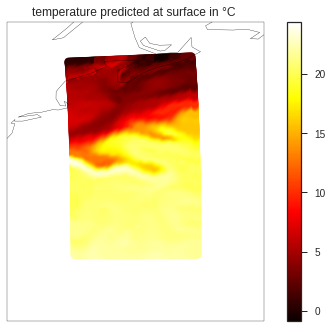

In [0]:
ax = plt.axes(projection=ccrs.PlateCarree())
CS3 =ax.scatter(lat_lng_patch_flat[:,1],lat_lng_patch_flat[:,0],c=Y_predicted[:,0],transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()
title("temperature predicted at surface in °C ")
plt.colorbar(CS3)
plt.show()

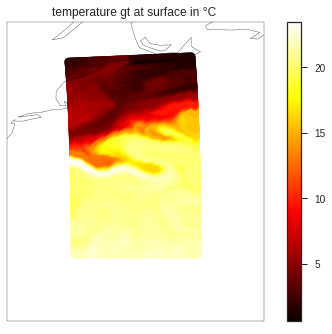

In [0]:
ax = plt.axes(projection=ccrs.PlateCarree())
CS3 =ax.scatter(lat_lng_patch_flat[:,1],lat_lng_patch_flat[:,0],c=temp_depth[0,:],transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()
title("temperature gt at surface in °C ")
plt.colorbar(CS3)
plt.show()

In [0]:
# Compute the error RMS
RMS_lab = sqrt(mean((Y_predicted - temp_depth.T)**2,1))
Abs_err = np.abs(Y_predicted - temp_depth.T)

In [0]:
# Create a convex hull of the agulhas region :
from scipy.spatial import ConvexHull
points = lat_lng
hull = ConvexHull(points)

def point_in_hull(point, hull, tolerance=1e-12):
    in_hull=True
    for eq in hull.equations:
        if np.dot(eq[:-1], point) + eq[-1] > tolerance:
            in_hull=False
    return(in_hull)
ind_in_hull = np.where([point_in_hull(lat_lng_patch_flat[k,:],hull) for k in tqdm(range(len(lat_lng_patch_flat)))])
ind_in_hull=ind_in_hull[0]

100%|██████████| 27474/27474 [00:00<00:00, 37264.88it/s]


In [0]:
to_plot =np.random.randint(len(lat_lng_patch_flat[ind_in_hull,0]),size=(len(lat_lng_patch_flat[ind_in_hull,0])//25))

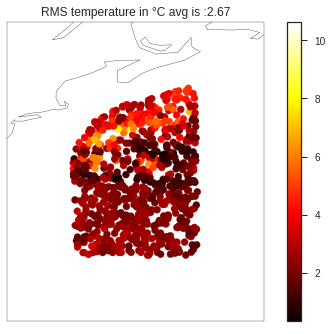

In [0]:
ax = plt.axes(projection=ccrs.PlateCarree())
CS3 =ax.scatter(lat_lng_patch_flat[ind_in_hull[to_plot],1],lat_lng_patch_flat[ind_in_hull[to_plot],0],c=RMS_lab[ind_in_hull[to_plot]],transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()
title("RMS temperature in °C avg is :"+str(round(np.mean(RMS_lab[ind_in_hull[to_plot]]),2)))
plt.colorbar(CS3)
plt.show()

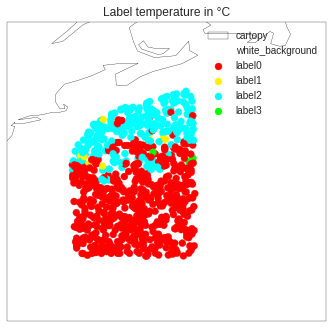

In [0]:
color=["#FF0000","#FFF000","#00FFFF","#00FF00"]
color_label = [color[label_attributed[ind_in_hull][to_plot[k]]] for k in range(len(to_plot))]


ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(0,0,c=color[0])
ax.scatter(0,0,c=color[1])
ax.scatter(0,0,c=color[2])
ax.scatter(0,0,c=color[3])
ax.legend(['cartopy','white_background','label0','label1','label2','label3'])
CS3 =ax.scatter(lat_lng_patch_flat[ind_in_hull[to_plot],1],lat_lng_patch_flat[ind_in_hull[to_plot],0],c=color_label,transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 10+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()

title("Label temperature in °C")
plt.show()


#### Check if in aghulas region

In [0]:
from scipy.spatial import ConvexHull
points = lat_lng
hull = ConvexHull(points)

def point_in_hull(point, hull, tolerance=1e-12):
    in_hull=True
    for eq in hull.equations:
        if np.dot(eq[:-1], point) + eq[-1] > tolerance:
            in_hull=False
    return(in_hull)

In [0]:
Execute_experiment=False
if Execute_experiment:#Extract indexes in aghulas
  lat_lng_patch =np.zeros((2,nx-patch_length_lon,ny-patch_length_lat))
  in_aghulas = []
  for l in tqdm(range(patch_length_lon,nx-patch_length_lon-1)):
    for j in range(patch_length_lat,ny-patch_length_lat-1):
      ilat, ilon = j, l
      # print(ilat,ilon,itim)
      patch = extract_patch(SLA,SST,ilat,ilon,itim)
      lat_lng_patch[0,l,j] = patch['nav_lat'][6,6].values
      lat_lng_patch[1,l,j] =patch['nav_lon'][6,6].values
      in_Hull = point_in_hull(lat_lng_patch[:,l,j],hull)
      if in_Hull:
        in_aghulas.append((j,l))



In [0]:
save_res=False
if save_res : 
  f = open('/content/in_aghulas_couple.pckl', 'wb')
  pickle.dump(in_aghulas, f)
  f.close()
  f = open('/content/lat_lng_ds.pckl', 'wb')
  pickle.dump(lat_lng_patch, f)
  f.close()
  from google.colab import files
  files.download('/content/in_aghulas_couple.pckl')
  files.download('/content/lat_lng_ds.pckl')

LOAD FILE IN AGHULAS 

#### Select 1000 samples randomly

In [0]:
if Execute_experiment:
  n_samples_region = len(in_aghulas)
  n_to_keep = 1000
  ind_to_keep = np.array([k for k in range(1,n_samples_region,20)][:n_to_keep])
  in_aghulas_kept =np.array(in_aghulas)[ind_to_keep]
  
  period = range(1,292,11)

Create 4D structure

In [0]:
if Execute_experiment:
  Features_t = np.zeros((len(period)*n_to_keep,13*13*2))
  target_t = np.zeros((len(period)*n_to_keep,36))


In [0]:
Execute_experiment=False
if Execute_experiment:
  for itim_ind in tqdm(range(len(period))):
    itim = period[itim_ind]
    for k in range(n_to_keep):
        ilat, ilon = in_aghulas_kept[k] #j, l

        patch = extract_patch(SLA,SST,ilat,ilon,itim)
        SST_ = patch['SST'].values.flatten()
        SLA_ = patch['SLA'].values.flatten()
        lat_lng_patch[0,l,j] = patch['nav_lat'][6,6].values
        lat_lng_patch[1,l,j] =patch['nav_lon'][6,6].values

        temp_depth = ds['votemper'].isel(time_counter=itim,y=ilat,x=ilon).values
        target_t[itim_ind*n_to_keep+k,:] = temp_depth
        # Merge:
        features = np.concatenate((SLA_, SST_)).flatten()
        Features_t[itim_ind*n_to_keep+k,:] = features

In [0]:
if save_res : 
  f = open('/content/target_features_t_10.pckl', 'wb')
  pickle.dump([target_t,Features_t], f)
  f.close()

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp /content/target_features_t_10.pckl /content/gdrive/My\ Drive/OceanographyProject/target_features_t_10.pckl

### LOAD PREVIOUSLY GENERATED FEATURES AND TARGET

In [186]:
gdd.download_file_from_google_drive(file_id = '1ueGB4mxbKGvtycZXfBRophtyWWS3f7Uu',dest_path = '/content/in_aghulas_couple.pckl',unzip=False)


In [187]:
gdd.download_file_from_google_drive(file_id = '1-1I_CJbrmgeqYZoRD1UIa11gC91V4NG4',dest_path = '/content/target_features_t_10.pckl',unzip=False)

In [188]:
gdd.download_file_from_google_drive(file_id = '12TisvExXCaGvEMh01ZFPmqnNu2U-9YA0',dest_path = '/content/lat_lng_ds.pckl',unzip=False)


In [0]:
f = open('/content/lat_lng_ds.pckl', 'rb')
lat_lng_patch=  pickle.load(f)
f.close()

f = open('/content/in_aghulas_couple.pckl', 'rb')
in_aghulas=  pickle.load(f)
f.close()

f = open('/content/target_features_t_10.pckl', 'rb')
[target_t,Features_t]=  pickle.load(f)
f.close()

In [0]:
Features_t = replace_nan(Features_t)
target_t   = replace_nan(target_t)
temp_mat = target_t.reshape(27,1000,36)
period = range(1,292,11)

## TEST SEVERAL MODELS

### CNN

In [0]:
feature_cnn = Features_t.reshape(len(Features_t),2,13,13)
feature_cnn_1 = np.swapaxes(feature_cnn, 1,2)
feature_cnn_2 = np.swapaxes(feature_cnn_1, 2,3)

In [0]:
temp_pred_cnn = model_cnn.predict(feature_cnn_2)

In [0]:
RMSE_tot = np.sqrt(metrics.mean_squared_error(temp_pred_cnn,target_t))
abs_err  = np.mean(abs(temp_pred_cnn-target_t))


temp_pred_cnn_mat = temp_pred_cnn.reshape(27,1000,36)

# Compute the error RMS
RMS_lab = sqrt(mean((temp_pred_cnn_mat - temp_mat)**2,2))
Abs_err = np.mean(np.abs(temp_pred_cnn_mat - temp_mat))

In [0]:
n_samples_region = len(in_aghulas)
n_to_keep = 1000
ind_to_keep = np.array([k for k in range(1,n_samples_region,20)][:n_to_keep])
in_aghulas_kept =np.array(in_aghulas)[ind_to_keep]
in_aghulas_kept_0 = in_aghulas_kept[:1000]
in_aghulas_kept_0_lat_lng= lat_lng_patch[:,in_aghulas_kept_0[:,1],in_aghulas_kept_0[:,0]]

In [0]:
time_step =15
ax = plt.axes(projection=ccrs.PlateCarree())
CS3 =ax.scatter(in_aghulas_kept_0_lat_lng[1,:],in_aghulas_kept_0_lat_lng[0,:],c=RMS_lab[time_step,:],transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()
title("RMS predicted at surface in °C,avg =  " + str(np.round(np.mean(RMS_lab[time_step,:]),3)) + "Timestep="+str(time_step*11))
plt.colorbar(CS3)
plt.show()

RMS_avg 2.395
RMSE_tot 2.878641293921947
Abs_err 2.0240818744649336


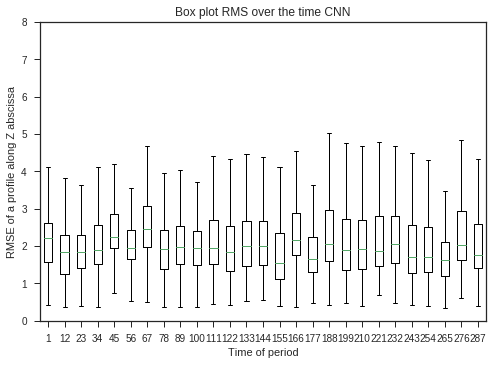

In [216]:
period = range(1,292,11)
plt.boxplot(RMS_lab.T,labels=period)
plt.ylim(0,8)
plt.xlabel('Time of period')
plt.ylabel('RMSE of a profile along Z abscissa')
plt.title('Box plot RMS over the time CNN')

print('RMS_avg', np.round(np.mean(RMS_lab),3))
print('RMSE_tot', RMSE_tot)
print('Abs_err', Abs_err)

### COMBINED EM MODEL

In [0]:
Y_predicted,label_att = em_model.predict(paramModel_em_model,Features_t)

RMSE_tot = np.sqrt(metrics.mean_squared_error(Y_predicted,target_t))
abs_err  = np.mean(abs(Y_predicted-target_t))

temp_mat = target_t.reshape(27,1000,36)
temp_pred_mat = Y_predicted.reshape(27,1000,36)
label_att_mat = label_att.reshape(27,1000)

# Compute the error RMS
RMS_lab = sqrt(mean((temp_pred_mat - temp_mat)**2,2))
Abs_err = np.mean(np.abs(temp_pred_mat - temp_mat))

RMS_avg 2.555
RMSE_tot 3.131561728872715
Abs_err 2.075947738129238


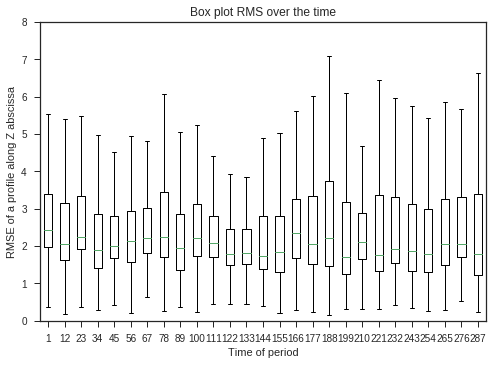

In [222]:
plt.boxplot(RMS_lab.T,labels=period)
plt.ylim(0,8)
plt.xlabel('Time of period')
plt.ylabel('RMSE of a profile along Z abscissa')
plt.title('Box plot RMS over the time')


print('RMS_avg', np.round(np.mean(RMS_lab),3))
print('RMSE_tot', RMSE_tot)
print('Abs_err', Abs_err)


### EM GT LABEL

In [0]:
Y_predicted,label_att = em_model_gt.predict(paramModel_em_model_gt,Features_t)

RMSE_tot = np.sqrt(metrics.mean_squared_error(Y_predicted,target_t))
abs_err  = np.mean(abs(Y_predicted-target_t))

temp_mat = target_t.reshape(27,1000,36)
temp_pred_mat = Y_predicted.reshape(27,1000,36)
label_att_mat = label_att.reshape(27,1000)

# Compute the error RMS
RMS_lab = sqrt(mean((temp_pred_mat - temp_mat)**2,2))
Abs_err = np.mean(np.abs(temp_pred_mat - temp_mat))

RMS_avg 2.104
RMSE_tot 2.480458110391976
Abs_err 1.7359204990299675


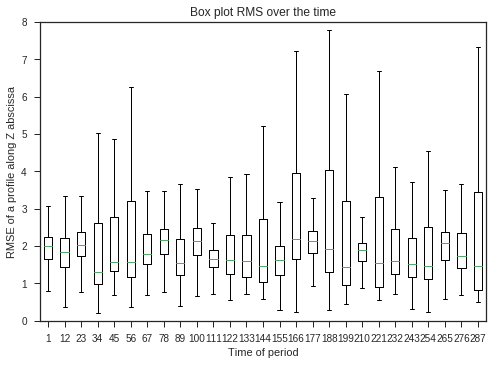

In [233]:
plt.boxplot(RMS_lab.T,labels=period)
plt.ylim(0,8)
plt.xlabel('Time of period')
plt.ylabel('RMSE of a profile along Z abscissa')
plt.title('Box plot RMS over the time')


print('RMS_avg', np.round(np.mean(RMS_lab),3))
print('RMSE_tot', RMSE_tot)
print('Abs_err', Abs_err)

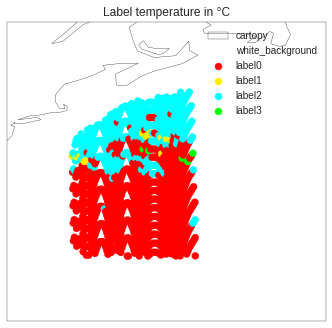

In [0]:
label_attributed = label_att_mat[0,:]
color=["#FF0000","#FFF000","#00FFFF","#00FF00"]
color_label = [color[label_attributed[k]] for k in range(len(label_attributed))]


ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(0,0,c=color[0])
ax.scatter(0,0,c=color[1])
ax.scatter(0,0,c=color[2])
ax.scatter(0,0,c=color[3])
ax.legend(['cartopy','white_background','label0','label1','label2','label3'])
CS3 =ax.scatter(in_aghulas_kept_0_lat_lng[1,:],in_aghulas_kept_0_lat_lng[0,:],c=color_label,transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 10+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()

title("Label temperature in °C")
plt.show()


### LINEAR MODEL 1


RMS_avg 2.12
RMSE_tot 2.5674163618830788
Abs_err 1.7153281992051241


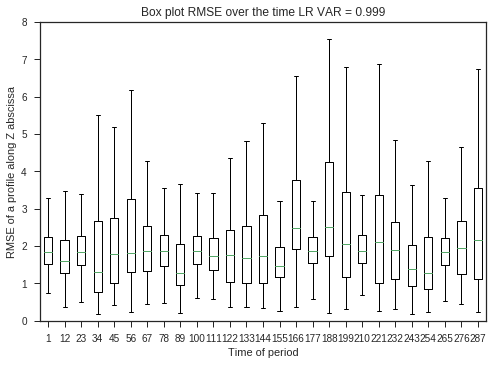

In [197]:
Y_predicted = model_linear.predict(paramModel,Features_t)
RMSE_tot = np.sqrt(metrics.mean_squared_error(Y_predicted,target_t))
Y_predicted_mat = Y_predicted.reshape(27,1000,36)
# Compute the error RMS
RMS_lab = sqrt(mean((Y_predicted_mat - temp_mat)**2,2))
abs_err = np.mean(np.abs(Y_predicted_mat - temp_mat))


plt.boxplot(RMS_lab.T,labels=period)
plt.ylim(0,8)
plt.xlabel('Time of period')
plt.ylabel('RMSE of a profile along Z abscissa')
plt.title('Box plot RMSE over the time LR VAR = 0.999')

print('RMS_avg', np.round(np.mean(RMS_lab),3))
print('RMSE_tot', RMSE_tot)
print('Abs_err', abs_err)


### LINEAR MODEL 2

RMS_avg 2.099
RMSE_tot 2.458531290667209
Abs_err 1.7280694914418155


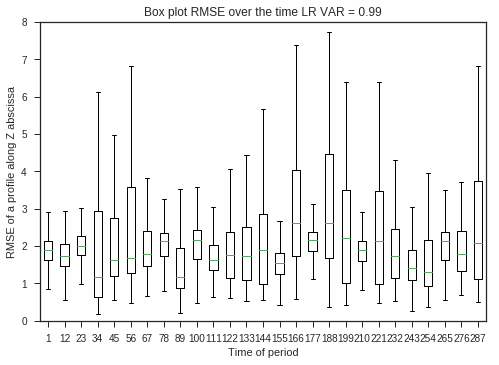

In [200]:
Y_predicted = model_linear99.predict(paramModel99,Features_t)
RMSE_tot = np.sqrt(metrics.mean_squared_error(Y_predicted,target_t))
Y_predicted_mat = Y_predicted.reshape(27,1000,36)
# Compute the error RMS
RMS_lab = sqrt(mean((Y_predicted_mat - temp_mat)**2,2))
abs_err = np.mean(np.abs(Y_predicted_mat - temp_mat))


plt.boxplot(RMS_lab.T,labels=period)
plt.ylim(0,8)
plt.xlabel('Time of period')
plt.ylabel('RMSE of a profile along Z abscissa')
plt.title('Box plot RMSE over the time LR VAR = 0.99')

print('RMS_avg', np.round(np.mean(RMS_lab),3))
print('RMSE_tot', RMSE_tot)
print('Abs_err', abs_err)

### EM - Kmeans model 1

RMS_avg 2.254
RMSE_tot 2.8296365905261056
Abs_err 1.806471582113217


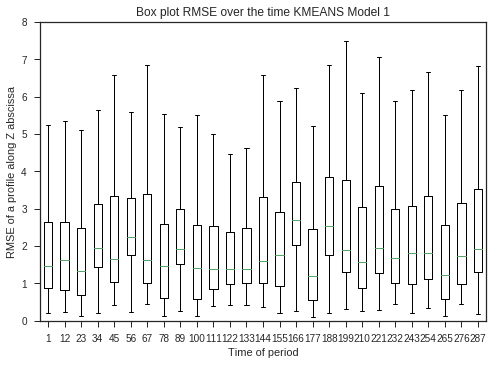

In [201]:
Y_predicted = model_kmeans_4.predict(paramModel_kmeans,Features_t)
RMSE_tot = np.sqrt(metrics.mean_squared_error(Y_predicted,target_t))
Y_predicted_mat = Y_predicted.reshape(27,1000,36)
# Compute the error RMS
RMS_lab = sqrt(mean((Y_predicted_mat - temp_mat)**2,2))
abs_err = np.mean(np.abs(Y_predicted_mat - temp_mat))


plt.boxplot(RMS_lab.T,labels=period)
plt.ylim(0,8)
plt.xlabel('Time of period')
plt.ylabel('RMSE of a profile along Z abscissa')
plt.title('Box plot RMSE over the time KMEANS Model 1')

print('RMS_avg', np.round(np.mean(RMS_lab),3))
print('RMSE_tot', RMSE_tot)
print('Abs_err', abs_err)



### EM - Kmeans model 2

RMS_avg 2.692
RMSE_tot 3.045114223100559
Abs_err 2.2058175689952306


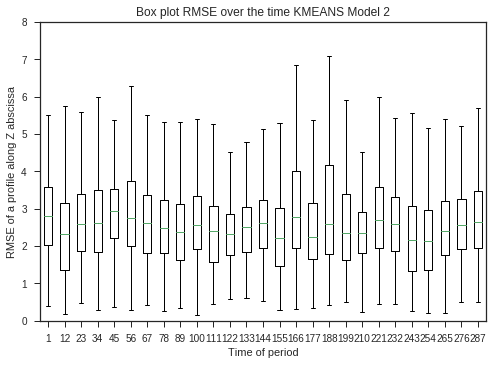

In [203]:
Y_predicted = model_kmeans_4_99.predict(paramModel_kmeans_99,Features_t)
RMSE_tot = np.sqrt(metrics.mean_squared_error(Y_predicted,target_t))
Y_predicted_mat = Y_predicted.reshape(27,1000,36)
# Compute the error RMS
RMS_lab = sqrt(mean((Y_predicted_mat - temp_mat)**2,2))
abs_err = np.mean(np.abs(Y_predicted_mat - temp_mat))


plt.boxplot(RMS_lab.T,labels=period)
plt.ylim(0,8)
plt.xlabel('Time of period')
plt.ylabel('RMSE of a profile along Z abscissa')
plt.title('Box plot RMSE over the time KMEANS Model 2')

print('RMS_avg', np.round(np.mean(RMS_lab),3))
print('RMSE_tot', RMSE_tot)
print('Abs_err', abs_err)


### EM - Kmeans model 3

RMS_avg 2.207
RMSE_tot 2.6093312445687364
Abs_err 1.8283889380232061


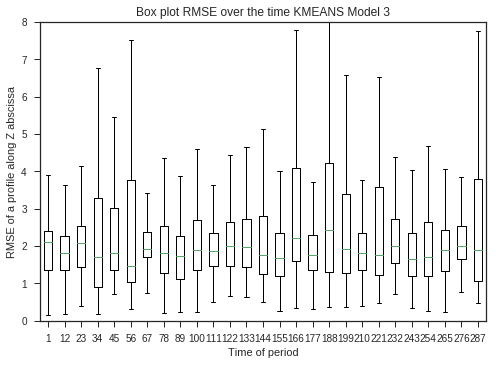

In [204]:
Y_predicted = model_kmeans_3_99.predict(paramModel_kmeans_3_99,Features_t)
RMSE_tot = np.sqrt(metrics.mean_squared_error(Y_predicted,target_t))
Y_predicted_mat = Y_predicted.reshape(27,1000,36)
# Compute the error RMS
RMS_lab = sqrt(mean((Y_predicted_mat - temp_mat)**2,2))
abs_err = np.mean(np.abs(Y_predicted_mat - temp_mat))


plt.boxplot(RMS_lab.T,labels=period)
plt.ylim(0,8)
plt.xlabel('Time of period')
plt.ylabel('RMSE of a profile along Z abscissa')
plt.title('Box plot RMSE over the time KMEANS Model 3')

print('RMS_avg', np.round(np.mean(RMS_lab),3))
print('RMSE_tot', RMSE_tot)
print('Abs_err', abs_err)


### EM - Kmeans model 4

RMS_avg 2.469
RMSE_tot 2.912404930152621
Abs_err 1.9820282855386926


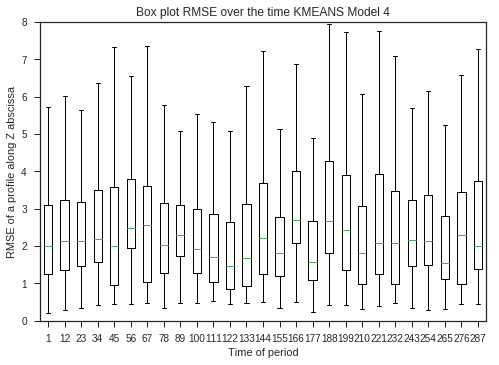

In [205]:
Y_predicted = model_kmeans_3.predict(paramModel_kmeans_3,Features_t)
RMSE_tot = np.sqrt(metrics.mean_squared_error(Y_predicted,target_t))
Y_predicted_mat = Y_predicted.reshape(27,1000,36)
# Compute the error RMS
RMS_lab = sqrt(mean((Y_predicted_mat - temp_mat)**2,2))
abs_err = np.mean(np.abs(Y_predicted_mat - temp_mat))


plt.boxplot(RMS_lab.T,labels=period)
plt.ylim(0,8)
plt.xlabel('Time of period')
plt.ylabel('RMSE of a profile along Z abscissa')
plt.title('Box plot RMSE over the time KMEANS Model 4')

print('RMS_avg', np.round(np.mean(RMS_lab),3))
print('RMSE_tot', RMSE_tot)
print('Abs_err', abs_err)


# SUMMARY RESULTS

| MODEL\SET                   | Xtrain | Xeval | Xtest |
|-----------------------------|--------|-------|-------|
| Linear Model  PCA = 0.999   |        |       |       |
| MAE                         | 1,96   | 2,09  | 1,72  |
| RMSE                        | 2,75   | 2,96  | 2,57  |
| KMEANS K=4 PCA= 0.999       |        |       |       |
| MAE                         | 1.54   | 1.86  | 1,81  |
| RMSE                        | 2.39   | 2.88  | 2,83  |
| KMEANS K=3 PCA= 0.999       |        |       |       |
| MAE                         | 1,65   | 1,96  | 1,98  |
| RMSE                        | 2,51   | 2,99  | 2,91  |
| EM Combined PCA = 0.999 K=4 |        |       |       |
| MAE                         | 1,49   | 1,9   | 2,07  |
| RMSE                        | 2,33   | 2,95  | 3,13  |
| Linear Model  PCA = 0.99    |        |       |       |
| MAE                         | 2,12   | 2,23  | 1,73  |
| RMSE                        | 2,93   | 3,15  | 2,46  |
| KMEANS K=4 PCA = 0.99       |        |       |       |
| MAE                         | 2,05   | 2,26  | 2,21  |
| RMSE                        | 3,31   | 3,52  | 3,04  |
| KMEANS K=3 PCA= 0.99        |        |       |       |
| MAE                         | 1,93   | 2,03  | 1,83  |
| RMSE                        | 2,85   | 3     | 2,61  |
| CNN                         |        |       |       |
| MAE                         |        |       | 2,02  |
| RMSE                        |        |       | 2,87  |


See BoxPLot CNN for more interpretation 




# **PLAYGROUND **

A place to test anything





In [0]:
lat_lng_train= np.zeros((len(lats),2))
lat_lng_train[:,0]= lats
lat_lng_train[:,1]= lons

In [0]:
to_plot =np.random.randint(size(ind_in_hull),size=(size(ind_in_hull)//5))
ind_to_plot= ind_in_hull[to_plot]

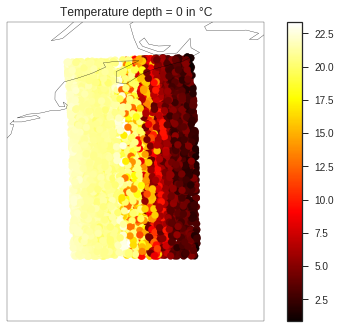

In [0]:
depth_=0
ax = plt.axes(projection=ccrs.PlateCarree())
CS3 =ax.scatter(lat_lng_patch_flat[ind_to_plot,1],lat_lng_patch_flat[ind_to_plot,0],c=temp_depth[ind_to_plot,depth_],transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()
title("Temperature depth = "+str(depth_)+" in °C")
plt.colorbar(CS3)
plt.show()

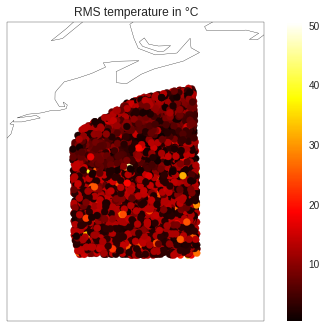

In [0]:
ax = plt.axes(projection=ccrs.PlateCarree())
CS3 =ax.scatter(lat_lng_patch_flat[ind_to_plot,1],lat_lng_patch_flat[ind_to_plot,0],c=RMS_lab[ind_to_plot],transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()
title("RMS temperature in °C")
plt.colorbar(CS3)
plt.show()

Text(0.5, 1.0, 'mean abs err temp')

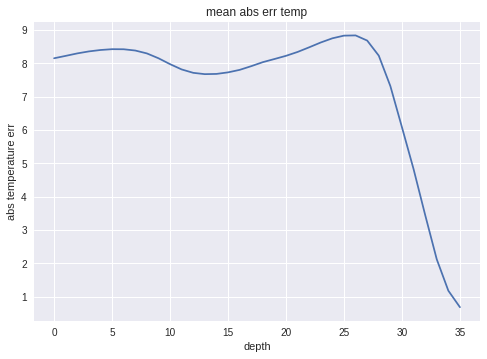

In [0]:
plt.plot(np.mean(Abs_err[ind_in_hull],0))
plt.xlabel('depth')
plt.ylabel('abs temperature err')
plt.title('mean abs err temp')

Text(0.5, 1.0, 'min abs err temp')

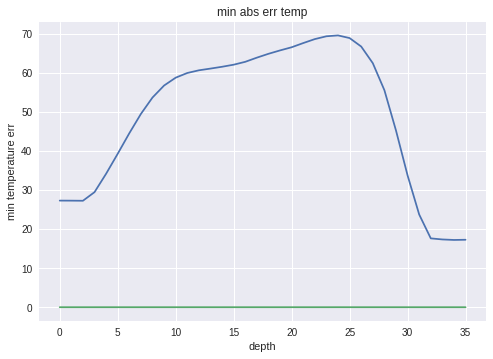

In [0]:
plt.plot(np.max(Abs_err[ind_in_hull],0))
plt.xlabel('depth')
plt.ylabel('max temperature err')
plt.title('max abs err temp')


Text(0.5, 1.0, 'min abs err temp')

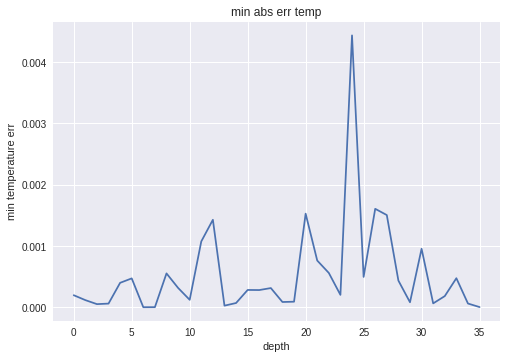

In [0]:

plt.plot(np.min(Abs_err[ind_in_hull],0))
plt.xlabel('depth')
plt.ylabel('min temperature err')
plt.title('min abs err temp')

mean(RMSE) = 7.91°C
min(RMSE) =  0.4°C
max(RMSE) = 51.58°C


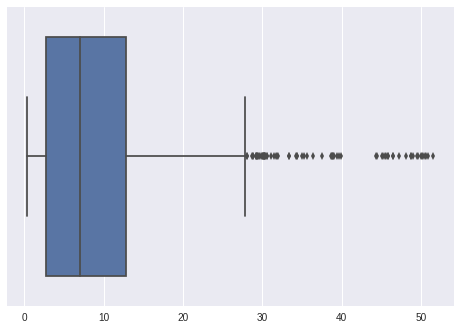

In [0]:
# Statistic about the prediction

print("mean(RMSE) = "+str(round(mean(RMS_lab[ind_in_hull]),2)) +"°C")
print("min(RMSE) =  "+str(round(min(RMS_lab[ind_in_hull]),2)) +"°C")
print("max(RMSE) = "+str(round(max(RMS_lab[ind_in_hull]),2)) +"°C")
sns.boxplot(RMS_lab[ind_in_hull])

In [0]:
color=["#FF0000","#FFF000","#00FFFF","#00FF00"]
color_label = [color[label_attributed[ind_to_plot][k]] for k in range(len(ind_to_plot))]
label_attributed

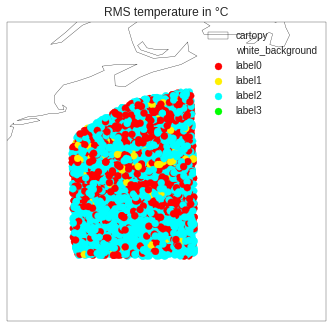

In [0]:
color=["#FF0000","#FFF000","#00FFFF","#00FF00"]
color_label = [color[label_attributed[ind_to_plot][k]] for k in range(len(ind_to_plot))]
label_attributed

ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(0,0,c=color[0])
ax.scatter(0,0,c=color[1])
ax.scatter(0,0,c=color[2])
ax.scatter(0,0,c=color[3])
ax.legend(['cartopy','white_background','label0','label1','label2','label3'])
CS3 =ax.scatter(lat_lng_patch_flat[ind_to_plot,1],lat_lng_patch_flat[ind_to_plot,0],c=color_label,transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 10+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()

title("RMS temperature in °C")
plt.show()

In [0]:
lat =lat_lng_patch_flat[:,0]
lon=lat_lng_patch_flat[:,1]
print("min lat = ", min(lat))
print("min lats = ", min(lats))

print("min lon = ", min(lon))
print("min lons = ", min(lons))

print("max lon = ", max(lon))
print("max lons = ", max(lons))

lat_lng_patch=lat_lng_patch.T

In [0]:
n_neighbors=10
x = np.arange(min(lons),max(lons), 0.05)
y = np.arange(min(lats),max(lats), 0.05)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.zeros((yy.shape[0],xx.shape[1]))
for j in tqdm(range(yy.shape[0])):
    for l in range(xx.shape[1]):
        duet =(yy[j,0],xx[0,l])
        mean_value,dist_=nearest_neighbors(duet,lat_lng_patch_flat[ind_to_plot,:],RMS_lab[ind_to_plot],n_neighbors)
        z[j,l] =mean_value    
ax1 = plt.axes(projection=ccrs.PlateCarree())
CS3 = plt.contourf(xx[0,:], yy[:,0], z, 60,
            transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax1.set_extent([-5+min(lons), 5+max(lons), -3+min(lats),5+max(lats)])
ax1.coastlines()
plt.colorbar(CS3)
plt.show()

In [0]:
# Load data
patch_length_lon = 14 # Half zonal length of the patch
patch_length_lat = 14 # Half meridional length of the patch
filename = ("ALLPATCHES_NX%i_NY%i.nc")%(2*patch_length_lon+1,2*patch_length_lat+1)

# Load patches:
ds = xr.open_dataset(filename)

label = ds['LABEL'].isel().values[np.newaxis]
temp = ds['TEMP'].isel().values
sla = ds['SLA'].isel()#.stack(features=('latitude','longitude'))
sst = ds['SST'].isel()#.stack(features=('latitude','longitude'))


# Merge:
features = np.zeros((533,29,29,2))
features[:,:,:,0]=sla
features[:,:,:,1]=sst

lat = ds['lat'].isel()
lon = ds['lon'].isel()

lat  = lat[:,14,14].values
long = lon[:,14,14].values

In [0]:
f = open('store_ds_patch.pckl', 'wb')
pickle.dump([label,temp,features,lat,long], f)
f.close()

100%|██████████| 26/26 [00:10<00:00,  2.42it/s]


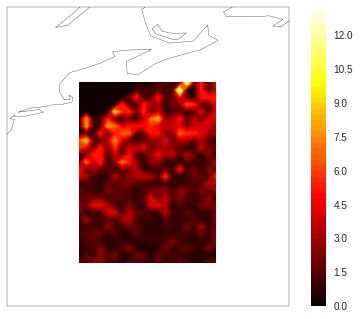

In [0]:
n_neighbors=1
x = np.arange(min(lons),max(lons), 0.5)
y = np.arange(min(lats),max(lats), 0.5)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.zeros((yy.shape[0],xx.shape[1]))
for j in tqdm(range(yy.shape[0])):
    for l in range(xx.shape[1]):
        duet =(xx[0,l],yy[j,0])
        mean_value,dist_=nearest_neighbors(duet,lng_lat,RMS_lab,n_neighbors)
        if dist_>0.5:
            z[j,l] =0
        else:
            z[j,l] =mean_value
            
ax1 = plt.axes(projection=ccrs.PlateCarree())
CS3 = plt.contourf(xx[0,:], yy[:,0], z, 60,
            transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax1.set_extent([-5+min(lons), 5+max(lons), -3+min(lats),5+max(lats)])
ax1.coastlines()
plt.colorbar(CS3)
plt.show()

In [0]:
# Define function to smooth the heatmap
def norm_2(x,y):
    """
    Compute the norm L2 : ||x-y||2
    """
    dim = len(x)
    norm = 0
    for j in range(dim):
        norm+= (x[j]-y[j])**2
    return(sqrt(norm))

def nearest_neighbors(duet, lng_lat, z_value, n_neighbors):
    """
    Aim to guess the value of Z given a duet = (x,y) using the neighbors of duet and their known z_value
    
    Input : 
        - duet    : position we want to estimate z_values with n_neighbors
        - lng_lat : couple of latitude, longitude value for which z is known
        - z_value : value we want to estimate for a given duet
        - n_neighbors : number of neighbors we want to use for the estimation
    
    """
    len_lons= len(lons)
    
    # Store the distance to later extract the nearest neighbors
    distance = []
    for p in range(len_lons):
        distance.append(norm_2(duet,lng_lat[p,:]))
    
    # Select the nearest neighbors using distance list
    index_of_interest=[]
    for ind in range(n_neighbors):
        index_min = np.argmin(distance)
        index_of_interest.append(index_min)
        if ind==0:
            dist_ =distance.pop(index_min)
            
    # Compute the mean of the neighbors z_value
    mean_value=0
    for ind in range(n_neighbors):
        mean_value += z_value[index_of_interest[ind]]
    mean_value=mean_value/n_neighbors
    
    # Return the estimated z_value and the distance to the closest neighbor used  (useful later)
    return(mean_value,dist_)
  
def nearest_neighbors_rms(duet, lng_lat, z_value,z_true_value, n_neighbors):
    """
    Aim to guess the value of Z given a duet = (x,y) using the neighbors of duet and their known z_value
    
    Input : 
        - duet    : position we want to estimate z_values with n_neighbors
        - lng_lat : couple of latitude, longitude value for which z is known
        - z_value : value we want to estimate for a given duet
        - n_neighbors : number of neighbors we want to use for the estimation
    
    """
    len_lons= len(lons)
    
    # Store the distance to later extract the nearest neighbors
    distance = []
    for p in range(len_lons):
        distance.append(norm_2(duet,lng_lat[p,:]))
    index_minn = np.argmin(distance)
    # Select the nearest neighbors using distance list
    index_of_interest=[]
    for ind in range(n_neighbors):
        index_min = np.argmin(distance)
        index_of_interest.append(index_min)
        if ind==0:
            dist_ =distance.pop(index_min)
        
    # Compute the mean of the neighbors z_value
    mean_value=np.zeros(36)
    for ind in range(n_neighbors):
        mean_value += z_value[index_of_interest[ind],:]
    mean_value=mean_value/n_neighbors
    true_val = z_true_value[index_minn,:]
    
    rms_ = norm_2(mean_value,true_val)
    # Return the estimated z_value and the distance to the closest neighbor used  (useful later)
    return(rms_,dist_)
        

**Smoothes the heatmap with a KNN approach**

In [0]:
# Define the number of neighbors
n_neighbors=50

# Data manipulation to create a structure of type (longitude,latitude)
lons = lons.reshape(-1,1)
lats =lats.reshape(-1,1)
lng_lat = np.concatenate((lons, lats), axis=1)

x = np.arange(min(lons),max(lons), 0.5)
y = np.arange(min(lats),max(lats), 0.5)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.zeros((yy.shape[0],xx.shape[1]))
for j in tqdm(range(yy.shape[0])):
    for l in range(xx.shape[1]):
        duet =(xx[0,l],yy[j,0])
        mean_value,dist_=nearest_neighbors(duet,lng_lat,RMS_plan,n_neighbors)
        if dist_>0.5:
            z[j,l] =0
        else:
            z[j,l] =mean_value

100%|██████████| 26/26 [00:12<00:00,  2.10it/s]


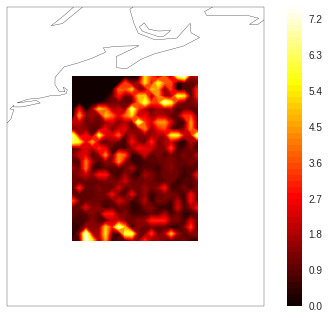

In [0]:
from scipy import interpolate
ax1 = plt.axes(projection=ccrs.PlateCarree())
CS3 = plt.contourf(xx[0,:], yy[:,0], z, 60,
            transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax1.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax1.coastlines()
plt.colorbar(CS3)
plt.show()

**Probability density estimation of the Gaussian mixture**

This will help estimate the latent mode given surfacic data.

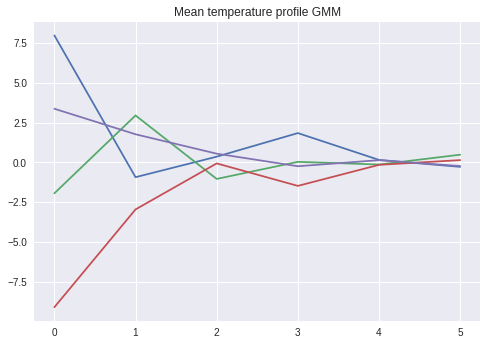

In [0]:
probability_density = zeros((len(X_orth),4))
multivariate_normal_law=[]
for label in range(4):   
    ind_label = find(label_pred==label)
    mean_ = mean(X_orth[ind_label,:],0)
    cov_  = cov(X_orth[ind_label,:].T)
    plt.plot(mean_)
    for k in range(len(X_orth)):
        probability_density[k,label]= multivariate_normal.pdf(X_orth[k,:], mean=mean_, cov=cov_)
    multivariate_normal_law.append(multivariate_normal(mean=mean_, cov=cov_))
    title('Mean temperature profile GMM')

**Attributing label with max pdf:**

In [0]:
label_attributed = np.argmax(probability_density,1)

In [0]:
ratio_good_assignment= len(find(label_attributed==label_pred))/len(label_attributed)
print(ratio_good_assignment)

0.6628895184135978


In [0]:
temp_pred_lab = temperature_profile(X_orth,Beta_hat,label_attributed)

# ACP inverse
temp_true_profile = acp_target.inverse_transform(temp_pred_lab) 

# Rescaling
rescale_temp =sc_target.inverse_transform(temp_true_profile) 


# Compute the error RMS
RMS_lab = sqrt(mean((rescale_temp - temp)**2,1))

mean(RMSE) = 2.17°C
min(RMSE) =  0.24°C
max(RMSE) = 13.06°C


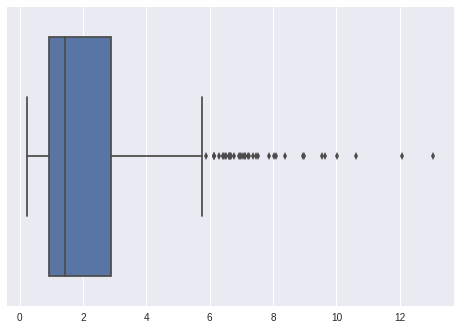

In [0]:
# Statistic about the prediction

print("mean(RMSE) = "+str(round(mean(RMS_lab),2)) +"°C")
print("min(RMSE) =  "+str(round(min(RMS_lab),2)) +"°C")
print("max(RMSE) = "+str(round(max(RMS_lab),2)) +"°C")
sns.boxplot(RMS_lab)

**Scatter RMS temperature with label prediction**

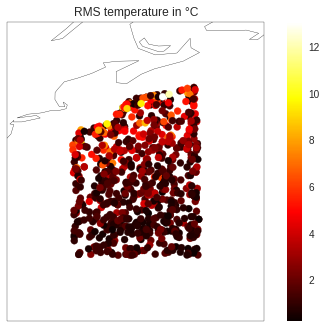

In [0]:
ax = plt.axes(projection=ccrs.PlateCarree())

CS3 =ax.scatter(lons.squeeze(),lats.squeeze(),c=RMS_lab,transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()
title("RMS temperature in °C")
plt.colorbar(CS3)
plt.show()

**Smoothes the heatmap with KNN**